<a href="https://colab.research.google.com/github/SalmaAbououkal/RecSys---Food-Rescue-Figures/blob/main/FoodWasteProject_penaltyTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import copy
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from collections import defaultdict
from google.colab import files

In [2]:
# Variables Intializations

class Config:
  THETA = 0.5             # MNL Theta
  OperatingTime = 9       # Platform Operating Time
  DAYS = 30               # Simulation Duration
  NA_AVG_Demand = 0.2     # Average demand for stores with 0 demand
  SCALE = 0.5             # Scale for log. regression
  # STORES_TEMP = 10        # Size of store subset
  BagPrice_Temp = 3.99    # Uniform Pricing Across All Stores
  attractiveness = 0.9    # Platform Popularity
  CustomersVolume = 0.85   # Customer Traffic set to 85% of available bags
  NoPurchase = 0
  updatedTuning = 0.3
  Noon = 12
  Alpha = 0.70

In [3]:
store_data = pd.read_csv('/content/drive/MyDrive/Food Waste Project/FinalStoresData.csv')

**Data Preprocessing**: To avoid any duplication in the data, we will keep only the first occurrence of each store, and for each store, we will aggregate the total demand and the average number of bags available at 9:00 AM.

Please note that both the *average bag listing* and *demand* were derived from data collected over two weeks. To estimate demand, we extracted data at three different times each day (9:00AM, 1:00PM, and 5:00PM). The demand was then approximated by subtracting the number of bags available at 5:00 PM from the number available at 9:00 AM, this difference reflects the reduction in inventory and thus it can be use as a proxy for how many bags were purchased (i.e., the store's demand).

In [4]:
store_data = store_data.groupby('store.store_id').agg({
    'store.store_name': 'first',          # Keep the first occurrence of store name
    'store.branch': 'first',              # Keep the first occurrence of branch
    'average_bags_at_9AM': 'first',       # Sum of average bags available at 9 AM
    'Demand': 'sum',                      # Sum of demand
    'store.store_location.location.longitude': 'first',  # Keep the first occurrence of location
    'store.store_location.location.latitude': 'first',   # Keep the first occurrence of location
    'item.average_overall_rating.average_overall_rating': 'first',  # Keep the first rating
    'item.price_including_taxes.minor_units': 'first',   # Keep the first price
    'item.item_category': 'first',   # Keep the first item category
    'item.value_including_taxes.minor_units': 'first'
}).reset_index()

store_data['Demand'] = store_data['Demand'].fillna(Config.NA_AVG_Demand)  # If average demand is naan, make it 0.2


# Set a rating of avg rating for the stores that are missing overall rating

AVG_rating = store_data['item.average_overall_rating.average_overall_rating'].mean()
store_data['item.average_overall_rating.average_overall_rating'] = store_data['item.average_overall_rating.average_overall_rating'].fillna(AVG_rating)

# Correctly representing the prices as decimal (For the MNL calculations)
store_data['item.price_including_taxes.minor_units'] = store_data['item.price_including_taxes.minor_units'] / 100
store_data['item.value_including_taxes.minor_units'] = store_data['item.value_including_taxes.minor_units'] / 100

# Ignoring the stores that has demand and avg bags equal to 0
store_data = store_data[(store_data['average_bags_at_9AM'] > 0) | (store_data['Demand'] > 0)]

# Remove stores with the category 'others' and those that have more than 20 bags

store_data = store_data[store_data['item.item_category'] != 'OTHER']
store_data = store_data[store_data['average_bags_at_9AM'] < 15]

store_data = store_data.reset_index(drop=True)

In [6]:
class Store:
    def __init__(self, storeID, storeName, storeBranch, storeRating, bagsAvailable, remainingBags,
                 bagPrice, itemStatus, demand, waste, valuation, updatedWaste, realizedWaste,CancelledOrders,
                 adjustedValuation, meanStoreVal, totalDemand, totalDemandNorm, Exposure, Chosen):

        self.storeID = storeID                          # Store ID
        self.storeName = storeName                      # Store Name
        self.storeBranch = storeBranch                  # Store Branch
        self.storeRating = storeRating                  # Store Rating
        # self.storeLocation = storeLocation              # Store Location
        self.bagsAvailable = bagsAvailable              # Store Bags Available (constant)
        self.remainingBags = remainingBags              # Store remaining bags
        self.bagPrice = bagPrice                        # Bag price
        # self.bagPrice = Config.BagPrice_Temp          # In case of uniform prices
        # self.itemCategory = itemCategory              # Store Category
        self.itemStatus = itemStatus                    # Status of the bag (sold, not sold)
        # self.itemValue = itemValue                    # Price/item value
        # self.demandScore = demandScore                # Avg demand for each store
        self.demand = demand                            # Store Demand
        # self.waste = waste                              # Waste after each day
        self.valuation = valuation                      # valuation
        self.realizedWaste = realizedWaste              # Store realized waste (RV)
        self.updatedWaste = updatedWaste                # Store updated waste
        self.CancelledOrders = CancelledOrders          # Store cancelled orders
        self.adjustedValuation = adjustedValuation      # Adjusted valuation after applying penalty
        self.meanStoreVal = meanStoreVal                    # mean valuation (for tracing and checking)
        self.totalDemand = totalDemand
        self.totalDemandNorm = totalDemandNorm
        self.Exposure = Exposure                              # Exposure to the store
        self.Chosen = Chosen                                 # How many times it was chosen

    def __str__(self):
        return f"Store: {self.storeName}, ID: {self.storeID} \n" \
               f"Store Branch: {self.storeBranch} \n" \
               f"Store Rating: {self.storeRating} \n" \
               f"Bags Available: {self.bagsAvailable} \n" \
               f"Remaining Bags: {self.remainingBags} \n" \
               f"Bags Price: {self.bagPrice} \n" \
               f"Daily Demand: {self.demand}\n" \
               f"Updated Waste: {self.updatedWaste}\n" \
               f"Realized Waste: {self.realizedWaste}\n" \
               f"Cancelled Orders: {self.CancelledOrders}\n" \
               f"Initial Valuation: {self.valuation}\n" \
               f"Adjusted Valuation: {self.adjustedValuation}\n" \
               f"MEAN: {self.meanStoreVal}\n" \
               f"Total Demand: {self.totalDemand}" \
               f"Total Demand Normalized: {self.totalDemandNorm}" \
               f"Exposure: {self.Exposure}" \
               f"Chosen: {self.Chosen}"

# What is the rational behind this?

    def END_OF_DAY_WASTE(self):
        epsilon = np.random.uniform(-0.35, 0.35)             # Random variation between -35% and +35%
        self.realizedWaste = max(0, np.round(self.bagsAvailable * (1 + epsilon)))

    def Middday_Estimated_Waste(self):
      noise = np.random.uniform(-0.3, 0.3)  # Random variation between -30% and +30%
      estimate = ((1 - Config.updatedTuning) * self.bagsAvailable) + \
               (Config.updatedTuning * self.realizedWaste)
      self.updatedWaste = max(0, round(estimate * (1 + noise)))


In [7]:
def stores_initialization(InitialStores = None):
    stores = []

    if InitialStores is not None and not isinstance(InitialStores, dict):
        InitialStores = {s.storeID: s for s in InitialStores}

    for _, row in store_data.iterrows():
        store_id = row['store.store_id']

        # Re-intialize everything each day
        if InitialStores is not None and store_id in InitialStores:

            store = InitialStores[store_id]
            store.bagsAvailable   = np.ceil(row['average_bags_at_9AM'])
            store.remainingBags   = np.ceil(row['average_bags_at_9AM'])
            store.demand          = 0
            store.waste           = 0
            store.valuation       = 0
            store.updatedWaste    = 0
            store.realizedWaste   = 0
            store.CancelledOrders = 0
            store.adjustedValuation = 0
            store.meanStore       = 0

        else:

            #If it's day 1, then set everything from the data

            store = Store(
                storeID=row['store.store_id'],
                storeName=row['store.store_name'],
                storeBranch=row['store.branch'],
                storeRating=row['item.average_overall_rating.average_overall_rating'],
                bagsAvailable=np.ceil(row['average_bags_at_9AM']),
                remainingBags=np.ceil(row['average_bags_at_9AM']),
                bagPrice=row['item.price_including_taxes.minor_units'],
                itemStatus=False,
                demand=0,
                waste=0,
                valuation=0,
                updatedWaste=0,
                realizedWaste=0,
                CancelledOrders=0,
                adjustedValuation=0,
                meanStore=0,
                totalDemand=0,                    # cumulative across days
                totalDemandNorm=0,                 # cumulative-normalized
                Exposure=0,
                Chosen=0
            )

        stores.append(store)

    return stores

In [ ]:
# def stores_initialization():

#     stores = []

#     for _, row in store_data.iterrows():
#         store = Store(
#             storeID=row['store.store_id'],
#             storeName=row['store.store_name'],
#             storeBranch=row['store.branch'],
#             storeRating=row['item.average_overall_rating.average_overall_rating'],
#             # storeLocation=(row['store.store_location.location.latitude'], row['store.store_location.location.longitude']),
#             bagsAvailable=np.ceil(row['average_bags_at_9AM']),
#             remainingBags = np.ceil(row['average_bags_at_9AM']),
#             bagPrice=row['item.price_including_taxes.minor_units'],
#             #bagPrice = Config.BagPrice_Temp,
#             # itemCategory=row['item.item_category'],
#             itemStatus=False,
#             # itemValue=row['item.value_including_taxes.minor_units'],
#             # demandScore=row['Demand'],
#             demand=0,
#             waste=0,
#             valuation=0,
#             updatedWaste = 0,
#             realizedWaste=0,
#             CancelledOrders=0,
#             adjustedValuation=0,
#             meanStore = 0
#         )

#         stores.append(store)

#     return stores

In [8]:
class Customer:
    def __init__(self, customerID, customerArrival, status):
        self.customerID = customerID                     # Customer ID
        self.customerChoice = None             # Chosen Store
        self.customerArrival = customerArrival           # Customer Arrical
        self.status = status                             # Customer Status

    def __str__(self):
        return f"Customer ID: {self.customerID} \n" \
                f"Customer Arrived at: {self.customerArrival} \n" \
                f"Customer Store Choice: {self.customerChoice} \n" \
                f"Customer Status: {self.status} \n" \
                # f"Customer Valuation: {self.customerValuation} \n"

### **Tuning Parameters**

In [ ]:
def generate_customer_arrivalsTEST(scale, theta, days, AVERAGE_CUSTOMERS):

  stores = stores_initialization()
  arrivals = []
  LAMBDA = (AVERAGE_CUSTOMERS / Config.OperatingTime)
  store_valuations = defaultdict(list)

  AVG_STORE_RATING = np.mean([store.storeRating for store in stores])


  # for day in range(1, days + 1):
  customerID = 1

  num_of_arrival = np.random.poisson(LAMBDA * Config.OperatingTime)
  arrival_times = np.sort(np.random.uniform(0, Config.OperatingTime, num_of_arrival))

  for arrival_time in arrival_times:
    customer_entry = {
        # 'Day': day,
        'Customer ID': customerID,
        'Arrival Time': arrival_time + 9,  # Offset by start of operating time (9 AM)
    }
    for store in stores:
        multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scale))
        # print(multiplier)
        mean = store.bagPrice * multiplier
        store.meanStore = (mean+(0.57721*theta))
        valuation = np.random.gumbel(mean, theta)
        customer_entry[f'{store.storeID}'] = valuation
        store_valuations[store.storeID].append(valuation)

    # Add the entry for this customer
    arrivals.append(customer_entry)
    customerID+=1

  for store_id, valuations in store_valuations.items():
        mean_val = np.mean(valuations)
        var_val = np.var(valuations)
        print(f"Mean is {next(store.meanStore for store in stores if store_id == store.storeID)} Store {store_id}")
        print(f"Store {store_id} - Mean Valuation: {mean_val}, Variance {var_val} \n")

  return

Config.THETA = 10
Config.SCALE = 1
Config.DAYS = 30
generate_customer_arrivalsTEST(Config.SCALE ,Config.THETA, Config.DAYS, AVERAGE_CUSTOMERS = 10000)

Mean is 10.744206287167968 Store 392
Store 392 - Mean Valuation: 10.75846392852926, Variance 163.44518259290192 

Mean is 9.78731720339367 Store 9038
Store 9038 - Mean Valuation: 9.629416128994272, Variance 161.45295019950078 

Mean is 11.07619606220744 Store 9047
Store 9047 - Mean Valuation: 10.994765859203754, Variance 166.2826586735882 

Mean is 11.179361815352319 Store 9109
Store 9109 - Mean Valuation: 11.09368317303927, Variance 165.85481595799814 

Mean is 10.833664495436818 Store 9110
Store 9110 - Mean Valuation: 10.628070466503706, Variance 161.01966969045165 

Mean is 11.142725171873954 Store 9111
Store 9111 - Mean Valuation: 11.208608889663841, Variance 171.84061897126162 

Mean is 12.297925340244024 Store 9112
Store 9112 - Mean Valuation: 12.17034630951362, Variance 166.48350073352603 

Mean is 11.43451719056862 Store 9113
Store 9113 - Mean Valuation: 11.392703084284532, Variance 162.22269995603486 

Mean is 10.102779245204335 Store 9121
Store 9121 - Mean Valuation: 10.14577

In [ ]:
def tuning(scale_para, theta_para):
    stores = stores_initialization()
    AVG_STORE_RATING = np.mean([store.storeRating for store in stores])
    valuations = []

    for store in stores:
        # Logistic function to adjust for store rating sensitivity
        multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scale_para))
        # Expected mean valuation
        meanStore = store.bagPrice * multiplier
        # Generate valuations using Gumbel distribution
        store_valuations = np.random.gumbel(meanStore, theta_para, size=1000)

        valuations.extend(store_valuations)

    return np.array(valuations)

# Function to find best parameters
def find_best_params(scale_values, theta_values):
    results = {}

    for scale in scale_values:
        for theta in theta_values:
            valuations = tuning(scale, theta)
            avg_valuation = np.mean(valuations)
            within_range = np.sum((valuations >= 4) & (valuations <= 6)) / len(valuations)  # % of values in range

            results[(scale, theta)] = {
                "mean": avg_valuation,
                "in_range": within_range
            }

    return results


# Define a range of scale and theta values to test
scale_values = np.arange(1, 11, 1)
theta_values = np.arange(0.5, 10.5, 0.5)

# Run tuning
best_params = find_best_params(scale_values, theta_values)

optimal_params = max(best_params, key=lambda x: best_params[x]["in_range"])
optimal_scale, optimal_theta = optimal_params

# Print results
print(f"Optimal Scale: {optimal_scale}, Optimal Theta: {optimal_theta}")

Optimal Scale: 8, Optimal Theta: 0.5


In [ ]:
def tuning(scale_para, theta_para):
    stores = stores_initialization()
    AVG_STORE_RATING = np.mean([store.storeRating for store in stores])
    utilities = []

    for store in stores:
        multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scale_para))
        meanStore = store.bagPrice * multiplier

        store_valuation = np.random.gumbel(meanStore, theta_para, size=1000)
        utility = store_valuation - store.bagPrice

        utilities.extend(utility)

    return np.array(utilities)

def find_best_params(scale_range, theta_range):

  results = []
  for scale in scale_range:
    for theta in theta_range:
      AllUtilities = tuning(scale, theta)

      positive_ = np.mean(AllUtilities > 0)

      results.append({
          "SCALE": float(scale),
          "THETA": float(theta),
          "positive_utilities_percentage": float(positive_) * 100
      })

  filtered = [r for r in results if r["positive_utilities_percentage"] <= 65]

  if filtered:
      best_params = max(filtered, key=lambda r: r["positive_utilities_percentage"])
      print("Optimal:", best_params)
  else:
      print("None")

scale_values = np.linspace(1, 10, 10)
theta_values = np.linspace(0.5, 10.0, 20)

find_best_params(scale_values, theta_values)

Optimal: {'SCALE': 1.0, 'THETA': 0.5, 'positive_utilities_percentage': 64.98852459016393}


## **Stores Subset Initialization**


In [ ]:
def storesSubset(scale, days):

    stores = stores_initialization()
    stores_sorted = sorted(stores, key=lambda x: x.storeRating)
    subset_stores = stores[40:50]
    AvgSubsetRating = np.mean([store.storeRating for store in subset_stores])
    # print(AvgSubsetRating)

    valuations = []
    for store in subset_stores:
        multiplier = 2 / (1 + np.exp((AvgSubsetRating - store.storeRating) / scale))
        store.valuation = store.bagPrice * multiplier
        valuations.append(store.valuation)

    # print("\nSelected Store Valuations:")
    # for store in subset_stores:
    #     print(f"Store {store.storeID} - Rating: {store.storeRating:.2f}, Valuation: {store.valuation:.2f}")

    return subset_stores

# for s in storesSubset(Config.SCALE, Config.DAYS):
#   print(s.valuation)

## **Test Load Balance and Penalty Function**

In [9]:
def penaltyFairnessAware_(stores, size):

    for store in stores:
      if store.totalDemand == 0:
        store.adjustedValuation = store.valuation
      else:
        store.adjustedValuation = (Config.Alpha * store.valuation)
        + ((1 - Config.Alpha) * (store.totalDemandNorm))

    sorted_stores = sorted(stores, key=lambda x: x.adjustedValuation, reverse=True)
    recommendationSetFairnessAware = [store for store in sorted_stores if store.remainingBags > 0][:size]

    return recommendationSetFairnessAware

In [10]:
def penaltyBenchmark_(stores, size):

    for store in stores:
      # print(f"store valuation actual {store.valuation}")
      if store.remainingBags >= 1:
        store.adjustedValuation = store.valuation
      else:
        store.adjustedValuation = 0
      # print(f"store valuation adjusted {store.adjustedValuation}")

    sorted_stores = sorted(stores, key=lambda x: x.adjustedValuation, reverse=True)
    recommendationSetBenchmark = [store for store in sorted_stores if store.remainingBags > 0][:size]

    # recommended_store_ids = set()
    # recommendationSetBenchmark = []

    # recommendationSetBenchmark = [store for store in sorted_stores
    #                            if store.remainingBags > 0 and store.storeID not in recommended_store_ids
    #                            and not recommended_store_ids.add(store.storeID)][:size]

    return recommendationSetBenchmark

In [11]:
# Linear

def penaltyLinear_(stores, size):

    for store in stores:
      # print(f"store valuation actual {store.valuation}")
      if store.remainingBags >= 1:
        penalty = (store.remainingBags / store.bagsAvailable)
        store.adjustedValuation = store.valuation * penalty
      else:
        store.adjustedValuation = store.valuation
      # print(f"store valuation adjusted {store.adjustedValuation}")

    sorted_stores = sorted(stores, key=lambda x: x.adjustedValuation, reverse=True)
    recommendationSetLinear = [store for store in sorted_stores if store.remainingBags > 0][:size]

    return recommendationSetLinear

In [12]:
# EXPONTENTIAL

def penaltyExp_(stores, size):
    para = 0.64         # a tunning parameter for a harsher penalty in stores that gets more demand
    for store in stores:
      # print(f"store valuation actual {store.valuation}")

      if store.remainingBags >= 1:
        x = (store.remainingBags / store.bagsAvailable)
        penalty = (math.e / (math.e - 1)) * (para - np.exp(-5*x))  # negative --> check paper
        store.adjustedValuation = store.valuation * penalty
      else:
        store.adjustedValuation = store.valuation
      # print(f"store valuation adjusted {store.adjustedValuation}")

    sorted_stores = sorted(stores, key=lambda x: x.adjustedValuation, reverse=True)
    recommendationSetExp = [store for store in sorted_stores if store.remainingBags > 0][:size]

    return recommendationSetExp

## **Testing**

In [ ]:
stores = storesSubset(Config.SCALE, Config.DAYS)
# max_iterations = max(store.remainingBags for store in stores)
# print(max_iterations)

for iteration in range(14):
    print(f"Iteration {iteration+1}: ", end="")

    rec1 = penaltyBenchmark_(stores, 3)
    print("Benchmark: ", [(store.storeID, float(store.remainingBags), float(store.adjustedValuation)) for store in rec1], end= " | " )
    print("")

    rec2 = penaltyLinear_(stores, 3)
    print("Linear: ", [(store.storeID, float(store.remainingBags), float(store.adjustedValuation)) for store in rec2], end= " | " )
    print("")


    rec3 = penaltyExp_(stores, 3)
    print("Exponential: ", [(store.storeID, (store.remainingBags), (store.adjustedValuation)) for store in rec3])
    print("")


    # print(f"Iteration {iteration+1}: ", end="")
    # print("Benchmark: ", [(store.storeID, store.valuation, store.adjustedValuation) for store in rec1], end= " | " )
    # print("Linear: ", [(store.storeID, store.adjustedValuation) for store in rec2], end= " | " )
    # print("Exponential: ", [(store.storeID, store.adjustedValuation) for store in rec3])

    for store in stores:
        if store.remainingBags > 0:
            store.remainingBags -= 1

In [ ]:
Remaining_Bags = np.arange(15, 0, -1)

initial_valuation = 5

linear_penalty = Remaining_Bags / max(Remaining_Bags)
linear_adjusted_valuation = initial_valuation * linear_penalty

x = Remaining_Bags / max(Remaining_Bags)
# k = 1 - (5 / max(Remaining_Bags))
# print(k)
exp_penalty = ((math.e / (math.e - 1)) * (0.64 - np.exp(-5*x)) )
exp_adjusted_valuation = initial_valuation * exp_penalty

plt.figure(figsize=(10, 6))
plt.plot(Remaining_Bags, linear_adjusted_valuation, label="Linear Penalty", color="green", linestyle="--")
plt.plot(Remaining_Bags, exp_adjusted_valuation, label="Exponential Penalty", color="blue", linestyle="-")
plt.xlabel("Remaining Bags")
plt.ylabel("Adjusted Valuation")
plt.title("Effect of Linear vs. Exponential Penalty on Store Valuation as Bags Decrease")
plt.legend()
plt.gca().invert_xaxis()
plt.show()

## **Daily Customer Processing**

In [26]:
KEYS_ = {"Day", "Customer ID", "Arrival Time"}

def CustomerPurchase(customer, recommended_stores, customer_data):

    recommended_by_id = {str(store.storeID): store for store in recommended_stores}

    decision_values = []
    chosen_store = None

    for store_id, valuation in customer_data.items():
        if store_id in KEYS_:
            continue

        # normalize store_id to string as well

        store = recommended_by_id.get(str(store_id))
        if store is None:
            continue

        price = store.bagPrice
        decision_value = valuation - price  # utility

        decision_values.append((decision_value, store))

    if not decision_values:
        customer.status = False
        customer.customerChoice = None
        customer.customerValuation = None
        return False

    max_decision_value, chosen_store = max(decision_values, key=lambda x: x[0])
    customer.customerValuation = max_decision_value

    if chosen_store is not None and max_decision_value > 0:
        chosen_store.remainingBags -= 1
        chosen_store.demand += 1
        customer.customerChoice = chosen_store.storeID
        customer.status = True
        return True

    customer.status = False
    customer.customerChoice = None
    return False


In [ ]:
# def process_customers(customer, recommended_stores, customer_arrivals):

#     customer_data = next(entry for entry in customer_arrivals if entry['Customer ID'] == customer.customerID)

#     non_negative_utility_count = 0
#     # print(f" Processing Customer {customer.customerID} Purchase : \n")

#     decision_values = []
#     chosen_store = None
#     recommendationSet = []

#     # print("Recommended Stores: ")
#     for store in recommended_stores:
#         # print(f"  - Store ID: {store.storeID}, Valuation: {store.valuation}, Remaining Bags: {store.remainingBags}")
#         recommendationSet.append(store.storeID)

#     #print("\n Customer Valuations:")

#     for store_id in customer_data.keys():
#       if store_id not in ['Day', 'Customer ID', 'Arrival Time']:

#         if str(store_id) in [str(store.storeID) for store in recommended_stores]:

#             store = next((store for store in recommended_stores if str(store.storeID) == str(store_id)), None)

#             if store:
#                 valuation = customer_data[store_id]  # This holds the valuation
#                 price = store.bagPrice
#                 decision_value = valuation - price # utility
#                 if decision_value >= 0:
#                     non_negative_utility_count += 1

#                 decision_values.append((decision_value, store))

#     # print(f"Stores with utility > 0: {non_negative_utility_count}")

#     if decision_values:

#         max_decision_value, chosen_store = max(decision_values, key=lambda x: x[0])  # Get the store with the max decision value
#         customer.customerValuation = max_decision_value


#     if chosen_store and max_decision_value > 0:  # If a store is chosen and decision value is positive

#         chosen_store.remainingBags -= 1  # Adjust the bags available
#         chosen_store.demand += 1  # Increase Store Demand
#         customer.customerChoice = chosen_store.storeID  # Update chosen store
#         customer.status = True  # Update customer status
#         # print(f"\n Customer {customer.customerID} CHOSE Store {chosen_store.storeID} with Utility {max_decision_value:.2f}!")
#     else:
#         # print("No store chosen for this customer.\n")
#         customer.status = False
#         chosen_store = None  # No store chosen

#     return customer.status

## **Customer Data**


In [13]:
def generate_customer_arrivals(stores, AVG_RATING, AVERAGE_CUSTOMERS, scale, theta):

  arrivals = []
  LAMBDA = (AVERAGE_CUSTOMERS / Config.OperatingTime) # AVG_Customer --> # of bags Customer volume is tunning parameter
  store_valuations = defaultdict(list)

  customerID = 1

  num_of_arrival = np.random.poisson(LAMBDA * Config.OperatingTime)
  arrival_times = np.sort(np.random.uniform(0, Config.OperatingTime, num_of_arrival))

  for arrival_time in arrival_times:
    customer_entry = {
        'Customer ID': customerID,
        'Arrival Time': arrival_time + 9,           # Offset by start of operating time (9 AM)
    }
    for store in stores:
        multiplier = 2 / (1 + np.exp((AVG_RATING - store.storeRating) / scale))
        # mean = multiplier
        mean = ( store.bagPrice * multiplier ) * Config.attractiveness
        #store.meanStore = (mean+(0.57721*theta))
        valuation = np.random.gumbel(mean, theta)

        customer_entry[f'{store.storeID}'] = valuation
        # print(f"customer {customerID}: {valuation} for store {store.storeID} and the price is {store.bagPrice}")
        utility = valuation - store.bagPrice
        # print(utility)
        store_valuations[store.storeID].append(utility)

    arrivals.append(customer_entry)
    customerID+=1

  for store_id, valuations in store_valuations.items():
      mean_val = np.mean(valuations)
      var_val = np.var(valuations)
      # print(f"Mean is {next(store.meanStore for store in stores if store_id == store.storeID)} Store {store_id}")
      # print(f"Store {store_id} - Mean Valuation: {mean_val}, Variance {var_val} \n")

  return arrivals, store_valuations

## **Sanity Check - Different Thetas**

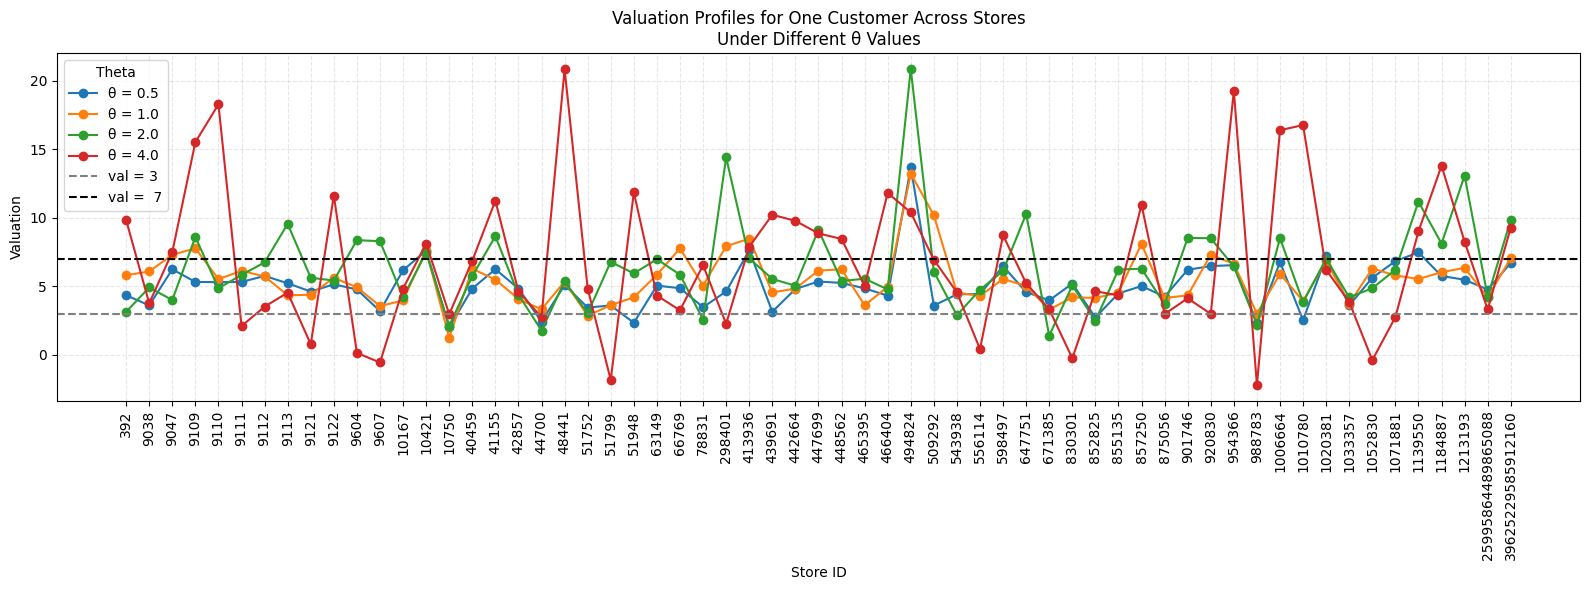

In [ ]:
stores = stores_initialization()
AVG_STORE_RATING = np.mean([store.storeRating for store in stores])
daily_bags_available = sum(store.bagsAvailable for store in stores)
customersRange = 0.85 * daily_bags_available

theta_values = [0.5, 1.0, 2.0, 4.0]
customer_index = 5
valuation_by_theta = {}

plt.figure(figsize=(16, 6))

for theta in theta_values:
    arrivals, _ = generate_customer_arrivals(
        stores, AVG_STORE_RATING, customersRange, scale=1, theta=theta
    )

    customer = arrivals[customer_index]
    valuations = {
        k: v for k, v in customer.items()
        if isinstance(k, str) and k not in ['Customer ID', 'Arrival Time']
    }
    store_ids = sorted(valuations.keys(), key=int)  # sorted numerically
    store_vals = [valuations[store] for store in store_ids]
    valuation_by_theta[theta] = store_vals
    plt.plot(store_ids, store_vals, label=f"θ = {theta}", marker='o')

plt.axhline(y = 3, color='gray', linestyle='--', linewidth=1.5, label='val = 3')
plt.axhline(y = 7, color='black', linestyle='--', linewidth=1.5, label='val =  7')

plt.title(f"Valuation Profiles for One Customer Across Stores\nUnder Different θ Values")
plt.xlabel("Store ID")
plt.ylabel("Valuation")
plt.xticks(rotation=90)
plt.legend(title="Theta")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
stores = stores_initialization()
AVG_STORE_RATING = np.mean([store.storeRating for store in stores])
daily_bags_available = sum(store.bagsAvailable for store in stores)
customersRange = 0.85 * daily_bags_available

theta_values = [0.5, 1, 5, 10]

for theta in theta_values:
    stores = stores_initialization()
    arrivals, _ = generate_customer_arrivals(
        stores, AVG_STORE_RATING, customersRange, scale=1, theta=theta
    )

    df = pd.DataFrame(arrivals)

    store_columns = [col for col in df.columns if isinstance(col, int) or str(col).isdigit()]
    df_val = df[store_columns]

    df_val.index.name = "Customer"

    save_path = f"/content/drive/MyDrive/Food Waste Project/CustomerUtilities_T{theta}_S1.csv"
    df_val.to_csv(save_path)

In [ ]:
stores = stores_initialization()
AVG_STORE_RATING = np.mean([store.storeRating for store in stores])
print(AVG_STORE_RATING)

count = 0
scale = 1
theta = 0.5

for store in stores:
  multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scale))
  mean = store.bagPrice * multiplier
  value = np.random.gumbel(mean, theta, 1000).mean()
  if value > store.bagPrice:
    count+=1

  print(f"store {store.storeID} with rating: {store.storeRating} and price {store.bagPrice} has a valuation of {value}")
print(count)

# **Timeframe and Realized Waste**

In [14]:
Config.DAYS = 30

In [15]:
realized_waste_data = pd.read_csv('/content/drive/MyDrive/Food Waste Project/EndOfDayWaste10Months.csv')
waste_within_date = realized_waste_data[(realized_waste_data['Day'] >= 1) & (realized_waste_data['Day'] <= Config.DAYS)]
waste_dict = waste_within_date.set_index(['Store ID', 'Day'])['Realized Waste'].to_dict()

## **Store Intialization (Beginning of the Day)**

In [16]:
def BeginningOfDayStores(prev_stores, day, scalePar):

    stores = stores_initialization(InitialStores= prev_stores)
    AvgRating = np.mean([store.storeRating for store in stores])

    for store in stores:
        multiplier = 2 / (1 + np.exp((AvgRating - store.storeRating) / scalePar))
        store.valuation = multiplier * store.bagPrice

        key = (store.storeID, day)
        if key in waste_dict:
            store.realizedWaste = waste_dict[key]

        store.Middday_Estimated_Waste()

    DailyBagsAvailable = sum(store.bagsAvailable for store in stores)

    return stores, AvgRating, DailyBagsAvailable

In [17]:
def DailyCustomersGeneration(stores, AvgRating, DailyBagsAvailable, scalePar, thetaPar):

    customers_range = Config.CustomersVolume * DailyBagsAvailable

    daily_arrivals, stores_valuations = generate_customer_arrivals(
        stores, AvgRating, customers_range, scalePar, thetaPar
    )

    customers = [
        Customer(
            customerID=arrival["Customer ID"],
            customerArrival=arrival["Arrival Time"],
            status=False,
        )
        for arrival in daily_arrivals
    ]

    total_customer_valuations = pd.DataFrame(stores_valuations)

    return customers, daily_arrivals, total_customer_valuations

In [46]:
stores = stores_initialization(InitialStores= None)
AvgRating = np.mean([store.storeRating for store in stores])
DailyBagsAvailable = sum(store.bagsAvailable for store in stores)

customers, arrivals, customerVals = DailyCustomersGeneration(stores, AvgRating, DailyBagsAvailable, scalePar = 8, thetaPar=0.5)
print(customerVals.head())


   392                9038               9047               9109               \
0           0.075962          -0.089231           0.080347          -2.278422   
1          -1.613073          -1.330623          -1.082712          -0.980399   
2          -0.534858           0.529704          -1.590560          -0.082620   
3          -1.336873          -0.792396          -1.435472          -1.286785   
4          -1.298871          -2.065299          -1.445958          -1.375662   

   9110               9111               9112               9113               \
0          -0.601534           0.034198          -1.869632          -1.403776   
1          -1.851562          -1.100808          -1.815726          -2.122833   
2          -2.027508           0.156251          -0.625875          -1.332629   
3          -1.932268          -1.633884          -1.729130          -1.367636   
4          -2.131124          -1.213745          -1.583062          -1.851116   

   9121               9122

In [33]:
def CustomerProcess(customers, stores, algorithmChoice, size, customer_data_map, end_of_day):

    for customer in customers:
        customer_data = customer_data_map[customer.customerID]
        recommendation_stores = algorithmChoice(stores, size=size)

        for s in recommendation_stores:
          s.Exposure += 1


        purchase_made = CustomerPurchase(
            customer,
            recommendation_stores,
            customer_data,
        )

        if purchase_made:
          # print("Customer Made a Purchase ")
          chosen_id = customer.customerChoice
            # find the store once
          for store in stores:
              if store.storeID == chosen_id:
                  store.Chosen+=1
                  end_of_day["Revenue"] += store.bagPrice
                  end_of_day["SoldBags"] += 1
                  break
        else:
          # print("No Purchase ")
          end_of_day["LeavingCustomers"] += 1

In [28]:
def WasteTracker(stores, daily_bags_available, end_of_day):

    for store in stores:
        if store.demand >= store.realizedWaste:
            store.CancelledOrders = store.demand - store.realizedWaste
            end_of_day["Cancelled_Orders"] += store.CancelledOrders
            end_of_day["Revenue"] -= store.CancelledOrders * store.bagPrice
            store.remainingBags = 0
            end_of_day["Waste_to_Customer"].append(1)

        elif store.demand < store.realizedWaste and store.demand != 0:
            waste_to_customer = store.realizedWaste / store.demand
            end_of_day["Waste_to_Customer"].append(waste_to_customer)
            store.remainingBags = 0

        if store.demand == 0:
            end_of_day["ZeroDemand_Stores"] += 1

    end_of_day["UnSoldBags"] = sum(store.remainingBags for store in stores)

    if daily_bags_available > 0:
        end_of_day["Waste_Percentage"] = (
            end_of_day["UnSoldBags"] / daily_bags_available
        ) * 100

In [22]:
# Only used for penaltyFairnessAware_()

def CumulativeDemand(stores):

    for s in stores:
        s.totalDemand += s.demand

    max_total = max(1, max(s.totalDemand for s in stores))
    for s in stores:
        s.totalDemandNorm = s.totalDemand / max_total

In [ ]:
def StoresProfile(stores):
  for s in stores:
    storesProfile = {
        "Store: " s.storeID,
        "Store Average Valuation ": ,
        "Store Exposure ": s.Exposure,
        "Store Chosen ": s.Chosen,
        "Store Demand ": s.demand,
        "Store Realized Waste ": s.realizedWaste,
    }

In [38]:
def simulateDiffSizes_(days, recommendation_sizes, scalePar, thetaPar, algorithmChoice=None):

    results = {alg_name: {size: [] for size in recommendation_sizes}
               for alg_name in algorithms}

    stores = None
    last_total_customer_valuations = None

    for day in range(1, days + 1):

        # --- Day setup ---
        stores, avg_store_rating, daily_bags_available = BeginningOfDayStores(
            prev_stores=stores,
            day=day,
            scalePar=scalePar,
        )


        # --- Customer generation ---

        customers, daily_arrivals, last_total_customer_valuations = DailyCustomersGeneration(
            stores,
            avg_store_rating,
            daily_bags_available,
            scalePar,
            thetaPar,
        )

        customer_data_map = {
            entry["Customer ID"]: entry
            for entry in daily_arrivals
        }


        # --- Run all algorithms & sizes for this day ---
        for alg_name, alg_fn in algorithms.items():
            for size in recommendation_sizes:

                stores_copy = copy.deepcopy(stores)
                customers_copy = copy.deepcopy(customers)

                end_of_day = {
                    "Algorithm": alg_name,
                    "Day": day,
                    "Recommendation Size": size,
                    "Revenue": 0,
                    "SoldBags": 0,
                    "UnSoldBags": 0,
                    "LeavingCustomers": 0,
                    "BagsAvailable": daily_bags_available,
                    "Waste_Percentage": 0,
                    "Cancelled_Orders": 0,
                    "ZeroDemand_Stores": 0,
                    "Waste_to_Customer": [],
                    "StoresExposure": {},
                    "StoresChoices": {}
                }

                CustomerProcess(
                    customers_copy,
                    stores_copy,
                    alg_fn,
                    size,
                    customer_data_map,
                    end_of_day,
                )

                # Update bags / waste metrics
                # for store in stores_copy:
                #     store.bagsAvailable = store.updatedWaste - store.demand

                end_of_day["StoresExposure"] = {s.storeID: s.Exposure for s in stores_copy}
                end_of_day["StoresChoices"] = {s.storeID: s.Chosen for s in stores_copy}

                WasteTracker(stores_copy, daily_bags_available, end_of_day)

                results[alg_name][size].append(end_of_day)

        # --- Cumulative updates after day finishes ---

        CumulativeDemand(stores)

    # --- Results to DataFrame ---

    data_frames = []
    for alg_name, size_data in results.items():
        for size, metrics in size_data.items():
            df = pd.DataFrame(metrics)
            # "Algorithm" and "Recommendation Size" are already in dict,
            # but we ensure consistency here.
            df["Algorithm"] = alg_name
            df["Recommendation Size"] = size
            data_frames.append(df)

    return pd.concat(data_frames, ignore_index=True), last_total_customer_valuations

In [39]:
Config.DAYS = 10
Config.CustomersVolume = 0.85
Config.attractiveness = 0.7

Config.THETA = 0.5
Config.SCALE = 1

Recom_sizes = [5, 10]

algorithms = {
    "Benchmark (Fairness-Based)": penaltyFairnessAware_,
    "Linear": penaltyLinear_,
    "Exponential": penaltyExp_
}

df_results, total_customer_vals = simulateDiffSizes_(
    days=Config.DAYS,
    recommendation_sizes=Recom_sizes,
    scalePar=Config.SCALE,
    thetaPar=Config.THETA,
)

In [ ]:
df_linear = df_results[df_results["Algorithm"] == "Linear"]

for _, row in df_linear.iterrows():
    print(f"\nDay {row['Day']} | k={row['Recommendation Size']}")
    print("Exposure:", row["StoresExposure"])
    print("Chosen:  ", row["StoresChoices"])

## **Simulation - Store Subset**


In [ ]:
def simulate_(days, RecommendationSize, scalePar, thetaPar, algorithmChoice):

    # STORE RESULTS FOE EACH ALG.
    #---------------------------------
    results = {alg_name: [] for alg_name in algorithms}
    recordsTracker = []


    # SIMULATION STARTS HERE
    #---------------------------------

    for day in range(1, days + 1):

        # Initialize all stores variables
        #---------------------------------

        stores = storesSubset(scalePar, days)                               # GENERATE STORES
        AVG_STORE_RATING = np.mean([store.storeRating for store in stores]) # RATING OF STORES

        # Store Waste and Valuation
        #-----------------------------
        for store in stores:
          multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scalePar))
          store.valuation = (store.bagPrice * multiplier)

          key = (store.storeID, day)
          if key in waste_dict:
              store.realizedWaste = waste_dict[key]

        # Customer-Related Variables
        #---------------------------------

        daily_bags_available = sum(store.bagsAvailable for store in stores)
        customersRange = 0.85 * daily_bags_available                          # 85% of inventory available
        daily_arrivals, storesValuations = generate_customer_arrivals(stores, AVG_STORE_RATING, customersRange, scalePar, thetaPar)

        customers = [
            Customer(
                customerID=arrival['Customer ID'],
                customerArrival=arrival['Arrival Time'],
                status=False
            )
            for arrival in daily_arrivals
        ]

        CustomerValuations = pd.DataFrame(storesValuations)

        # Start Day
        #---------------------------------

        for alg_name, algorithmChoice in algorithms.items():

            # Copy of customers and Store
            #----------------------------------

            copyCustomers= copy.deepcopy(customers)
            copyStores = copy.deepcopy(stores)

            # Needed Metrics
            #----------------------------------

            end_of_day = {
                'Algorithm': alg_name,
                'Day': day,
                'Recommendation Size': RecommendationSize,
                'Revenue': 0,
                'SoldBags': 0,
                'UnSoldBags': 0,
                'LeavingCustomers': 0,
                'BagsAvailable': daily_bags_available,
                'Percentage_UnsoldBags': 0,
                'Cancelled_Orders': 0,
                'ZeroDemand_Stores': 0,
                'Waste_to_Customer': []
            }

            # Customer Processing
            #----------------------------------
            for customer in copyCustomers:

                recommendation_strategy = algorithmChoice(copyStores, size=RecommendationSize)

                # if day == 1:

                #     print(f"Algorithm {alg_name}")
                #     print(f"Cusomer: {customer.customerID}")
                #     print([(store.storeID, store.storeName, store.remainingBags) for store in recommendation_strategy], end= " | ")

                purchase_made = process_customers(customer, recommendation_strategy, daily_arrivals)

                recordsTracker.append({
                    "Day": day,
                    "Algorithm": alg_name,
                    "CustomerID": customer.customerID,
                    "Recommendations": [(store.storeID, store.storeName, store.remainingBags) for store in recommendation_strategy],
                    "ChosenStore": customer.customerChoice if purchase_made else None,
                    # "CustomerValuation": customer.customerValuation,
                    "PurchaseMade": purchase_made
                })

                if purchase_made:
                    for store in copyStores:
                        if customer.customerChoice == store.storeID:
                            end_of_day['Revenue'] += store.bagPrice
                            end_of_day['SoldBags'] += 1
                else:
                    end_of_day['LeavingCustomers'] += 1

            # for c in copyCustomers:
            #   leavingCustomers = sum(1 for c in copyCustomers if not c.status)
            # print(leavingCustomers)

            waste_to_customer = 0
            for store in copyStores:
                if store.demand >= store.realizedWaste:
                    # print(f" Store {store.storeID} Store Demand is {store.demand} and realized waste is {store.realizedWaste}")
                    store.CancelledOrders = (store.demand - store.realizedWaste)
                    # print(f" Store {store.storeID} has {store.CancelledOrders} Cancelled Orders")
                    end_of_day['Cancelled_Orders'] += (store.demand - store.realizedWaste)
                    lost_revenue = store.CancelledOrders * store.bagPrice
                    end_of_day['Revenue'] -= lost_revenue
                    store.remainingBags = 0
                    end_of_day['Waste_to_Customer'].append(1)

                if store.demand <= store.realizedWaste and store.demand != 0:
                    waste_to_customer = store.realizedWaste / store.demand
                    # print(f"{store.storeName} has realized waste {store.realizedWaste} and a demand of {store.demand}")
                    # print(f"Resulting in a waste {waste_to_customer}, the store valuation is {store.valuation} \n")
                    end_of_day['Waste_to_Customer'].append(waste_to_customer)
                    store.remainingBags = 0

                if store.demand == 0:
                    end_of_day['ZeroDemand_Stores'] += 1


            # Calculate unsold bags
            end_of_day['UnSoldBags'] = sum(store.remainingBags for store in copyStores)
            if daily_bags_available > 0:
                end_of_day['Percentage_UnsoldBags'] = (end_of_day['UnSoldBags'] / daily_bags_available) * 100

            results[alg_name].append(end_of_day)

    results = pd.concat([
                          pd.DataFrame(data).assign(Algorithm=alg_name)
                          for alg_name, data in results.items()
                      ], ignore_index=True)

    tracker = pd.DataFrame.from_records(recordsTracker)

    return results, tracker, CustomerValuations


In [ ]:
Config.THETA = 0.5
Config.SCALE = 1
Recom_size = 3

algorithms = {"Benchmark": penaltyBenchmark_,
              "Linear": penaltyLinear_,
              "Exponential": penaltyExp_}

# print("Benchmark \n")
runSumulation, tracker, CustomerValuations = simulate_(days=Config.DAYS,
                      RecommendationSize=Recom_size,
                      scalePar = Config.SCALE,
                      thetaPar=Config.THETA,
                      algorithmChoice=algorithms)

# drive_path = "/content/drive/MyDrive/Food Waste Project/CustomerValuations_0.5.csv"
# CustomerValuations.to_csv(drive_path, index=False)

In [ ]:
runSumulation['Waste_to_Customer'] = runSumulation['Waste_to_Customer'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

exploded_df = (
    runSumulation.explode('Waste_to_Customer')
    .rename(columns={'Waste_to_Customer': 'WasteToCustomerRatio'})
    .reset_index(drop=True)
)

exploded_df['WasteToCustomerRatio'].replace([np.inf, -np.inf], np.nan)
waste_stats = exploded_df.groupby('Algorithm')['WasteToCustomerRatio'].agg(['mean', 'median', 'std', 'min', 'max'])
print(waste_stats)

                 mean    median       std min   max
Algorithm                                          
Benchmark    1.971166  1.076923  2.635050   1  18.0
Exponential  2.812513       1.7  3.138654   1  19.0
Linear       2.353647      1.75  2.323201   1  19.0


<ipython-input-30-a62cbe3b9d4a>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exploded_df['WasteToCustomerRatio'].replace([np.inf, -np.inf], np.nan)


In [ ]:
Days = range(Config.DAYS)

FalseBenchmark = tracker[(tracker["Algorithm"] == "Benchmark") & (tracker["PurchaseMade"] == False)]

LinearExp = tracker[
    (tracker["Algorithm"].isin(["Linear", "Exponential"])) &
    (tracker["PurchaseMade"] == True)
]

merged = FalseBenchmark.merge(LinearExp, on=["Day", "CustomerID"], suffixes=("_Benchmark", "_Other"))

FilteredData = merged[merged["Day"].isin(Days)]

drive_path = "/content/drive/MyDrive/Food Waste Project/Filtered.csv"
FilteredData.to_csv(drive_path, index=False)

## **Plots Comparison**

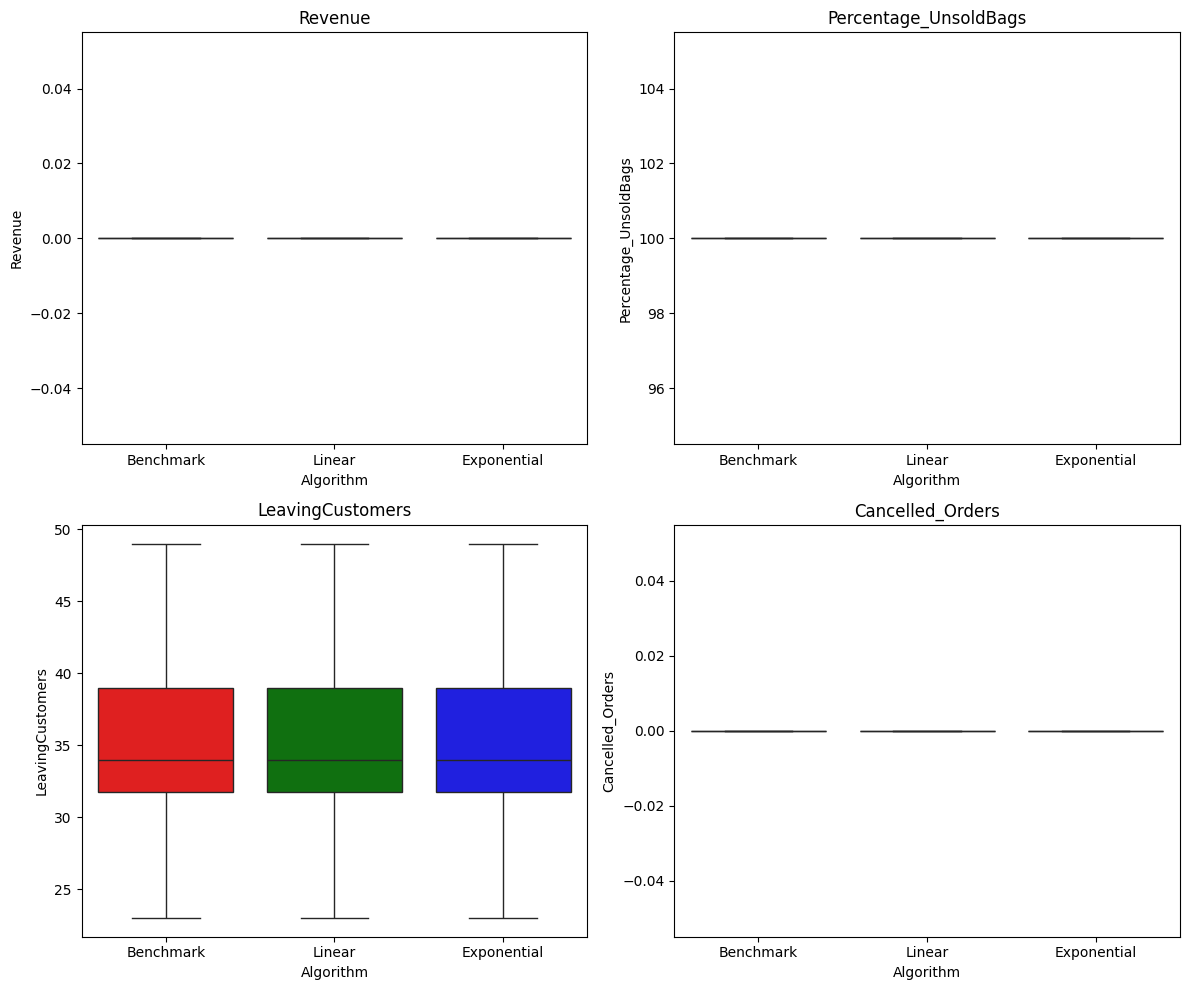

In [ ]:
metrics = ["Revenue", "Percentage_UnsoldBags", "LeavingCustomers", "Cancelled_Orders"]

Colorpalette = {"Benchmark": "red", "Linear": "green", "Exponential": "blue"}

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Generate boxplots for each metric across algorithms
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.boxplot(
        x="Algorithm", y=metric, data=runSumulation,
        palette=Colorpalette, ax=ax, hue="Algorithm", legend=False
    )

    ax.set_title(f"{metric}", fontsize=12)
    ax.set_xlabel("Algorithm")
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

## **Different Recommendation Sizes**

In [ ]:
def simulateDiffSizes_(days, recommendation_sizes, scalePar, thetaPar, algorithmChoice):

    results = {alg_name: {size: [] for size in recommendation_sizes} for alg_name in algorithms}

    stores = None
    for day in range(1, days + 1):

        stores = stores_initialization(prev_stores=stores)
        AVG_STORE_RATING = np.mean([store.storeRating for store in stores])

        for store in stores:
            multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scalePar))
            store.valuation = multiplier * store.bagPrice
            key = (store.storeID, day)
            if key in waste_dict:
                store.realizedWaste = waste_dict[key]

            store.Middday_Estimated_Waste()

        # Calculate daily bags available and generate customer arrivals
        daily_bags_available = sum(store.bagsAvailable for store in stores)

        # Only generate customers if there are bags available
        if daily_bags_available > 0:
            customersRange = Config.CustomersVolume * daily_bags_available
            daily_arrivals, storesValuations = generate_customer_arrivals(stores, AVG_STORE_RATING, customersRange, scalePar, thetaPar)
            # print(f"Customers arrived: {len(daily_arrivals)}\n")

            customers = [
                Customer(
                    customerID=arrival['Customer ID'],
                    customerArrival=arrival['Arrival Time'],
                    status=False
                )
                for arrival in daily_arrivals
            ]

            TotalCustomerValuations = pd.DataFrame(storesValuations)


            # Simulate for each algorithm and recommendation size
            for alg_name, algorithmChoice in algorithms.items():
                for size in recommendation_sizes:

                    copyCustomers = copy.deepcopy(customers)
                    copyStores = copy.deepcopy(stores)

                    # Initialize end-of-day metrics
                    end_of_day = {
                        'Algorithm': alg_name,
                        'Day': day,
                        'Recommendation Size': size,
                        'Revenue': 0,
                        'SoldBags': 0,
                        'UnSoldBags': 0,
                        'LeavingCustomers': 0,
                        'BagsAvailable': daily_bags_available,
                        'Waste_Percentage': 0,
                        'Cancelled_Orders': 0,
                        'ZeroDemand_Stores': 0,
                        'Waste_to_Customer': []
                    }

                    for customer in customers:
                        recommendation_strategy = algorithmChoice(copyStores, size=size)
                        purchase_made = process_customers(customer, recommendation_strategy, daily_arrivals)
                        if purchase_made:
                            for store in copyStores:
                                if customer.customerChoice == store.storeID:
                                    end_of_day['Revenue'] += store.bagPrice
                                    end_of_day['SoldBags'] += 1
                        else:
                            end_of_day['LeavingCustomers'] += 1


                    for store in copyStores:
                      store.bagsAvailable = store.updatedWaste - store.demand

                    for customer in copyCustomers:
                        recommendation_strategy = algorithmChoice(copyStores, size=size)
                        purchase_made = process_customers(customer, recommendation_strategy, daily_arrivals)
                        if purchase_made:
                            for store in copyStores:
                                if customer.customerChoice == store.storeID:
                                    end_of_day['Revenue'] += store.bagPrice
                                    end_of_day['SoldBags'] += 1
                        else:
                            end_of_day['LeavingCustomers'] += 1

                    # Calculate waste and other metrics
                    for store in copyStores:
                        if store.demand >= store.realizedWaste:
                            store.CancelledOrders = store.demand - store.realizedWaste
                            end_of_day['Cancelled_Orders'] += store.CancelledOrders
                            end_of_day['Revenue'] -= store.CancelledOrders * store.bagPrice
                            store.remainingBags = 0
                            end_of_day['Waste_to_Customer'].append(1)

                        if store.demand < store.realizedWaste and store.demand != 0:
                            waste_to_customer = store.realizedWaste / store.demand
                            end_of_day['Waste_to_Customer'].append(waste_to_customer)
                            store.remainingBags = 0

                        if store.demand == 0:
                            end_of_day['ZeroDemand_Stores'] += 1

                    # Calculate unsold bags
                    end_of_day['UnSoldBags'] = sum(store.remainingBags for store in copyStores)
                    if daily_bags_available > 0:
                        end_of_day['Waste_Percentage'] = (end_of_day['UnSoldBags'] / daily_bags_available) * 100

                    # Append the results for this algorithm and recommendation size
                    results[alg_name][size].append(end_of_day)
        else:
             # If no bags available, record zero metrics for all algorithms and sizes
            for alg_name in algorithms:
                for size in recommendation_sizes:
                     end_of_day = {
                        'Algorithm': alg_name,
                        'Day': day,
                        'Recommendation Size': size,
                        'Revenue': 0,
                        'SoldBags': 0,
                        'UnSoldBags': 0,
                        'LeavingCustomers': 0,
                        'BagsAvailable': 0,
                        'Waste_Percentage': 0,
                        'Cancelled_Orders': 0,
                        'ZeroDemand_Stores': 0,
                        'Waste_to_Customer': []
                    }
                     results[alg_name][size].append(end_of_day)

        for s in stores:
          s.totalDemand += s.demand

        max_total = max(1, max(s.totalDemand for s in stores))

        for s in stores:
          s.totalDemandNorm = s.totalDemand / max_total


    # Convert results to DataFrames
    data_frames = []
    for alg_name, size_data in results.items():
        for size, metrics in size_data.items():
            df = pd.DataFrame(metrics)
            df['Algorithm'] = alg_name
            df['Recommendation Size'] = size
            data_frames.append(df)

    return pd.concat(data_frames, ignore_index=True), TotalCustomerValuations

In [ ]:
Config.CustomersVolume = 0.85
Theta_values = [0.5, 1, 2, 4]
Scale_values = [1, 2, 4, 8]

Recom_sizes = [5, 10, 15, 20]

algorithms = {
    "Benchmark (Fairness-Based)": penaltyFairnessAware_,
    "Linear": penaltyLinear_,
    "Exponential": penaltyExp_
}

attractiveness_ = {
    "Less Popular (α = 0.6)": 0.6,
    "Relatively Popular (α = 0.7)": 0.7,
    "Highly Popular (α = 0.8)": 0.8
}

results = {}

for theta in Theta_values:
    for scale in Scale_values:
        Config.THETA = theta
        Config.SCALE = scale

        key = (theta, scale)
        results[key] = {}

        for label, attract in attractiveness_.items():
            Config.attractiveness = attract

            runSim, _ = simulateDiffSizes_(
                days=Config.DAYS,
                recommendation_sizes=Recom_sizes,
                scalePar=Config.SCALE,
                thetaPar=Config.THETA,
                algorithmChoice=algorithms
            )

            results[key][label] = runSim

/tmp/ipython-input-2271733508.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  penalty = (store.remainingBags / store.bagsAvailable)
/tmp/ipython-input-338260021.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  x = (store.remainingBags / store.bagsAvailable)


In [ ]:
def simulateDiffSizes_(days, recommendation_sizes, scalePar, thetaPar, algorithmChoice):

    results = {alg_name: {size: [] for size in recommendation_sizes} for alg_name in algorithms}
    all_customer_valuations = []

    for day in range(1, days + 1):

        # --- Store Initialization ---

        stores = stores_initialization()
        avg_store_rating = np.mean([store.storeRating for store in stores])

        for store in stores:
            multiplier = 2 / (1 + np.exp((avg_store_rating - store.storeRating) / scalePar))
            store.valuation = multiplier * store.bagPrice
            key = (store.storeID, day)
            if key in waste_dict:
                store.realizedWaste = waste_dict[key]
            store.Middday_Estimated_Waste()

        daily_bags_available = sum(store.bagsAvailable for store in stores)

        # --- Customer Generation ---

        if daily_bags_available > 0:
            customers_range = Config.CustomersVolume * daily_bags_available
            daily_arrivals, stores_valuations = generate_customer_arrivals(
                stores, avg_store_rating, customers_range, scalePar, thetaPar
            )

            customers = [
                Customer(
                    customerID=arrival['Customer ID'],
                    customerArrival=arrival['Arrival Time'],
                    status=False
                ) for arrival in daily_arrivals
            ]

            all_customer_valuations.append(pd.DataFrame(stores_valuations))
            midday_threshold = Config.Noon

            for alg_name, algorithm_func in algorithms.items():
                for size in recommendation_sizes:
                    copy_customers = copy.deepcopy(customers)
                    copy_stores = copy.deepcopy(stores)

                    early_customers = [c for c in copy_customers if c.customerArrival < midday_threshold]
                    late_customers = [c for c in copy_customers if c.customerArrival >= midday_threshold]

                    # print(f"\n📅 Day {day} — Algorithm: {alg_name}, Size: {size}")
                    # print(f"🕒 Early customers: {len(early_customers)} | Late customers: {len(late_customers)}")

                    # for s in copy_stores[:5]:
                    #   print(f"  🏪 Store {s.storeID} — bags: {s.bagsAvailable}, "
                    #   f"updated: {s.updatedWaste:.2f}, realized: {s.realizedWaste}")


                    end_of_day = {
                        'Algorithm': alg_name,
                        'Day': day,
                        'Recommendation Size': size,
                        'Revenue': 0,
                        'SoldBags': 0,
                        'UnSoldBags': 0,
                        'LeavingCustomers': 0,
                        'BagsAvailable': daily_bags_available,
                        'Waste_Percentage': 0,
                        'Cancelled_Orders': 0,
                        'ZeroDemand_Stores': 0,
                        'Waste_to_Customer': []
                    }


                    # --- Morning Customers ---

                    for customer in early_customers:
                        recommendations = algorithm_func(copy_stores, size=size)
                        purchase = process_customers(customer, recommendations, daily_arrivals)
                        if purchase:
                            for store in copy_stores:
                                if customer.customerChoice == store.storeID:
                                    end_of_day['Revenue'] += store.bagPrice
                                    end_of_day['SoldBags'] += 1
                        else:
                            end_of_day['LeavingCustomers'] += 1


                    # --- Midday Waste Update ---

                    sold_bags = end_of_day['SoldBags']
                    leaving = end_of_day['LeavingCustomers']
                    # print(f"✅ Total sold so far: {sold_bags}, Customers left: {leaving}")

                    for store in copy_stores:
                      # if day == 3:
                        print(f"store {store.storeID} has initial waste of {store.bagsAvailable} and the updated waste is {store.updatedWaste} and so far the demand is {store.demand} \n")
                        store.bagsAvailable = store.updatedWaste - store.demand
                        print(f"store {store.storeID} has updated number of bags{store.bagsAvailable} \n")

                  # --- Afternoon Customers ---
                    for customer in late_customers:
                        recommendations = algorithm_func(copy_stores, size=size)
                        purchase = process_customers(customer, recommendations, daily_arrivals)
                        if purchase:
                            for store in copy_stores:
                                if customer.customerChoice == store.storeID:
                                    end_of_day['Revenue'] += store.bagPrice
                                    end_of_day['SoldBags'] += 1
                        else:
                            end_of_day['LeavingCustomers'] += 1

                    # for store in copy_stores[:5]:  # limit output
                    #   print(f"📦 Store {store.storeID} — Demand: {store.demand}, "
                    #   f"Realized: {store.realizedWaste}, Remaining: {store.remainingBags}")

                    # --- Final Waste Calculation ---
                    for store in copy_stores:
                        if store.demand >= store.realizedWaste:
                            store.CancelledOrders = store.demand - store.realizedWaste
                            end_of_day['Cancelled_Orders'] += store.CancelledOrders
                            end_of_day['Revenue'] -= store.CancelledOrders * store.bagPrice
                            store.remainingBags = 0
                            end_of_day['Waste_to_Customer'].append(1)
                        elif store.demand < store.realizedWaste and store.demand != 0:
                            waste_ratio = store.realizedWaste / store.demand
                            end_of_day['Waste_to_Customer'].append(waste_ratio)
                            store.remainingBags = 0
                        elif store.demand == 0:
                            store.remainingBags = store.realizedWaste
                            end_of_day['ZeroDemand_Stores'] += 1

                    end_of_day['UnSoldBags'] = sum(store.remainingBags for store in copy_stores)
                    if daily_bags_available > 0:
                        end_of_day['Waste_Percentage'] = (end_of_day['UnSoldBags'] / daily_bags_available) * 100

                    results[alg_name][size].append(end_of_day)

        else:
            for alg_name in algorithms:
                for size in recommendation_sizes:
                    results[alg_name][size].append({
                        'Algorithm': alg_name,
                        'Day': day,
                        'Recommendation Size': size,
                        'Revenue': 0,
                        'SoldBags': 0,
                        'UnSoldBags': 0,
                        'LeavingCustomers': 0,
                        'BagsAvailable': 0,
                        'Waste_Percentage': 0,
                        'Cancelled_Orders': 0,
                        'ZeroDemand_Stores': 0,
                        'Waste_to_Customer': []
                    })

    data_frames = []
    for alg_name, size_data in results.items():
        for size, metrics in size_data.items():
            df = pd.DataFrame(metrics)
            df['Algorithm'] = alg_name
            df['Recommendation Size'] = size
            data_frames.append(df)

    return pd.concat(data_frames, ignore_index=True), pd.concat(all_customer_valuations, ignore_index=True)

In [ ]:
Config.DAYS = 1
Config.THETA = 0.5
Config.SCALE = 1
Config.CustomersVolume = 0.85
Config.attractiveness = 0.7

Recom_sizes = [5, 10, 15, 20]

algorithms = {
    "Benchmark": penaltyBenchmark_,
    "Linear": penaltyLinear_,
    "Exponential": penaltyExp_
}

# Different accuracy levels of midday waste estimation
waste_update_levels = {
    # "No Update ": 0.0,
    "Moderate Accuracy Update": 0.3,
    "High Accuracy Update": 0.7
}

results = {}

for label, tuning in waste_update_levels.items():
    Config.updatedTuning = tuning


    runSim, _ = simulateDiffSizes_(
        days=Config.DAYS,
        recommendation_sizes=Recom_sizes,
        scalePar=Config.SCALE,
        thetaPar=Config.THETA,
        algorithmChoice=algorithms
    )

    results[label] = runSim

In [ ]:
results_df = pd.concat(
    [df.assign(TuningLabel=label) for label, df in results.items()],
    ignore_index=True
)

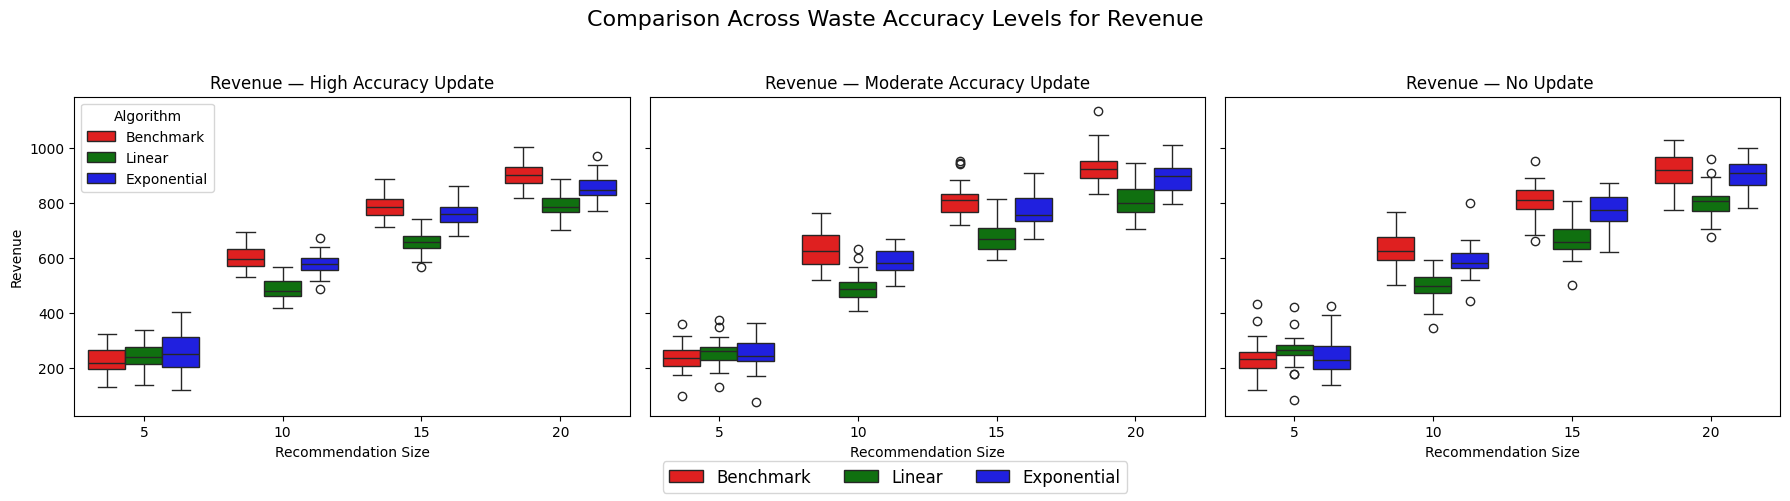

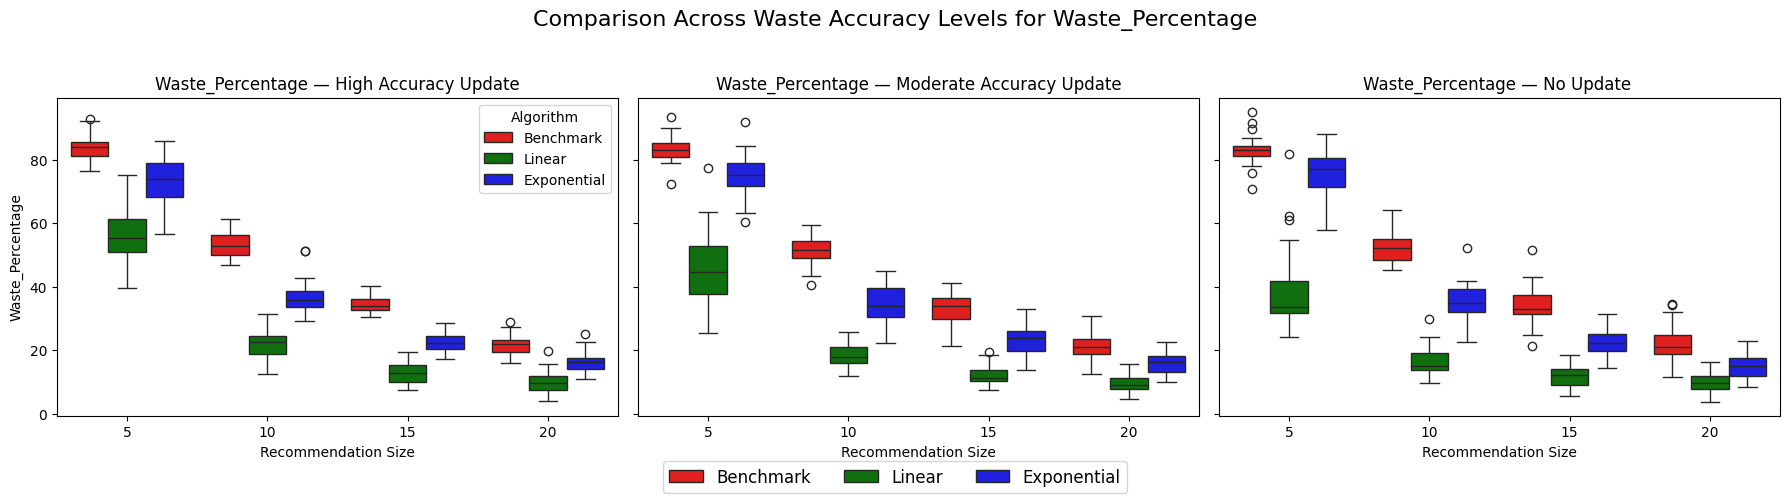

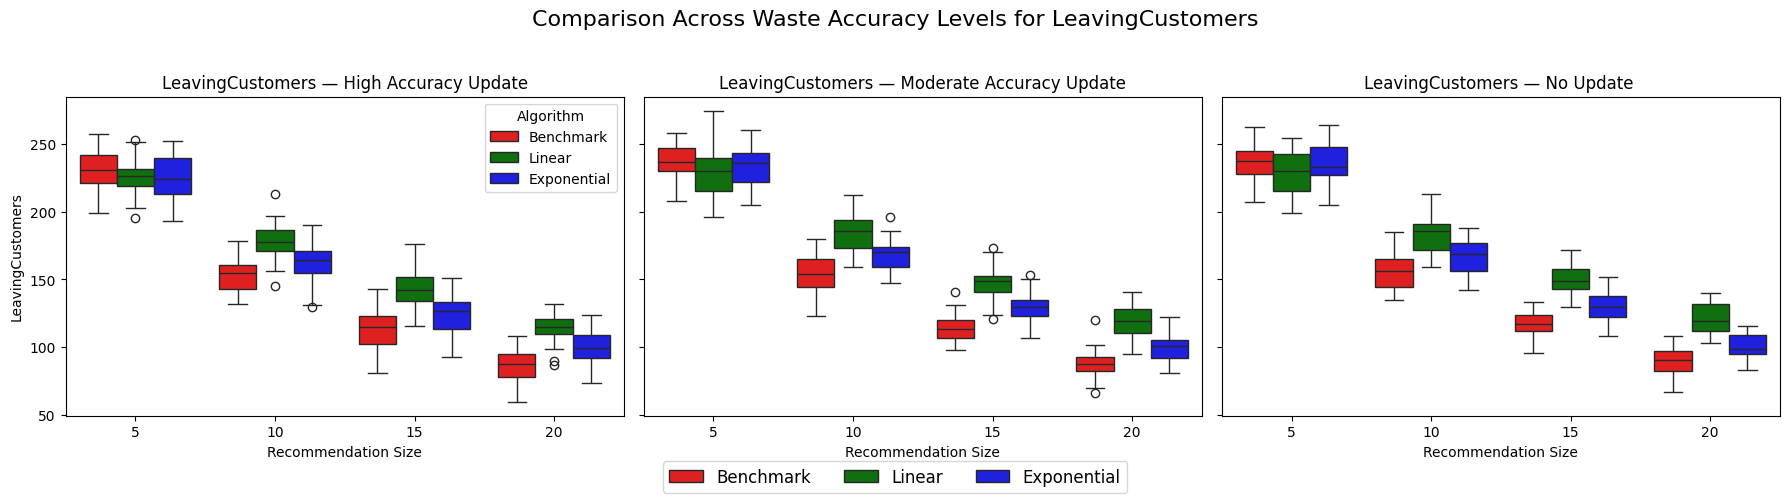

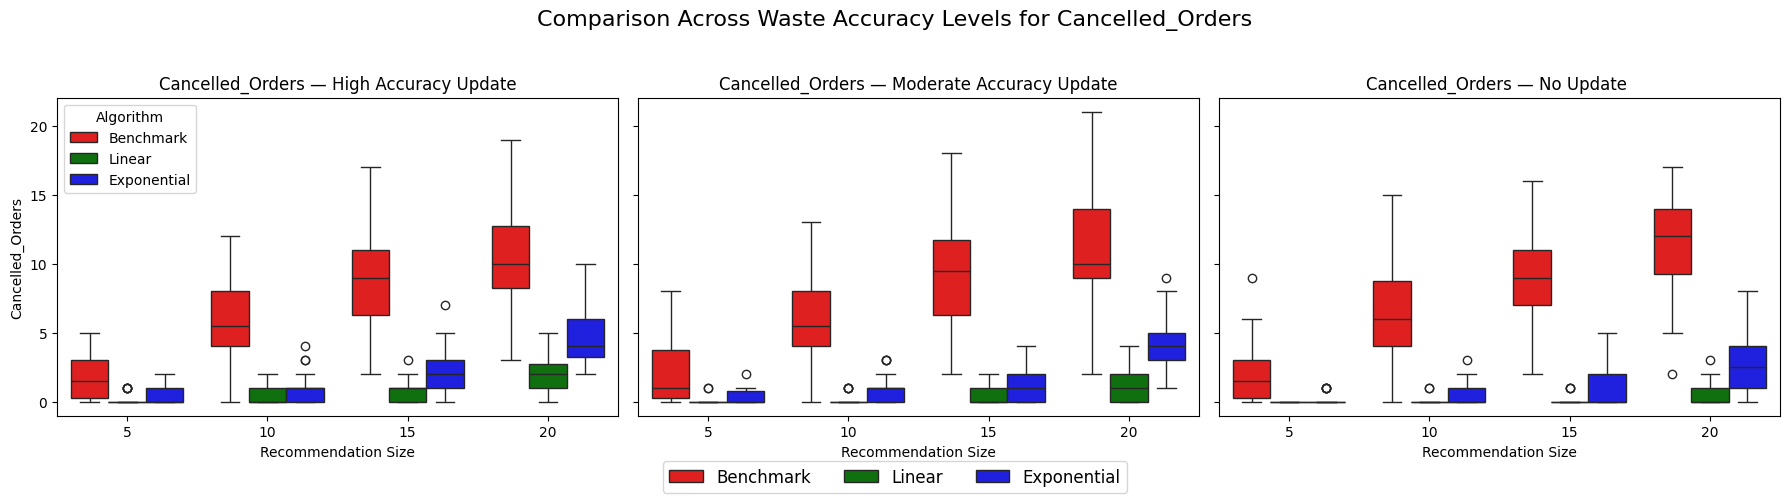

In [ ]:
colors = {
    "Benchmark": "red",
    "Linear": "green",
    "Exponential": "blue"
}
metrics = ["Revenue", "Waste_Percentage", "LeavingCustomers", "Cancelled_Orders"]
tuning_labels = results_df["TuningLabel"].unique()
n_cols = len(tuning_labels)

for metric in metrics:
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 5), sharey=True)
    if n_cols == 1:
        axes = [axes]

    for idx, label in enumerate(sorted(tuning_labels)):
        ax = axes[idx]
        subset = results_df[results_df["TuningLabel"] == label]

        sns.boxplot(
            data=subset,
            x="Recommendation Size",
            y=metric,
            hue="Algorithm",
            palette=colors,
            ax=ax
        )

        ax.set_title(f"{metric} — {label}")
        ax.set_xlabel("Recommendation Size")
        ax.set_ylabel(metric)
        if idx != 0:
            ax.get_legend().remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=12)

    plt.suptitle(f"Comparison Across Waste Accuracy Levels for {metric}", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

**Attractiveness**

In [ ]:
Config.CustomersVolume = 0.85
Theta_values = [0.5, 1, 2, 4]
Scale_values = [1, 2, 4, 8]

Recom_sizes = [5, 10, 15, 20]

algorithms = {
    "Benchmark": penaltyBenchmark_,
    "Linear": penaltyLinear_,
    "Exponential": penaltyExp_
}

attractiveness_ = {
    "Less Popular (α = 0.6)": 0.6,
    "Relatively Popular (α = 0.7)": 0.7,
    "Highly Popular (α = 0.8)": 0.8
}

# Results structure:
# results[(theta, scale)][attractiveness_label] = simulation output
results = {}

for theta in Theta_values:
    for scale in Scale_values:
        Config.THETA = theta
        Config.SCALE = scale

        key = (theta, scale)
        results[key] = {}

        for label, attract in attractiveness_.items():
            Config.attractiveness = attract

            runSim, _ = simulateDiffSizes_(
                days=Config.DAYS,
                recommendation_sizes=Recom_sizes,
                scalePar=Config.SCALE,
                thetaPar=Config.THETA,
                algorithmChoice=algorithms
            )

            results[key][label] = runSim

In [ ]:
all_records = []

for (theta, scale), data in results.items():
    for attract_label, df in data.items():
        df_copy = df.copy()

        df_copy["Theta"] = theta
        df_copy["Scale"] = scale
        df_copy["Attractiveness"] = attract_label

        df_copy = df_copy.rename(columns={"Algorithm": "PenaltyFunction"})

        all_records.append(df_copy)

results_df = pd.concat(all_records, ignore_index=True)


save_path = f"/content/drive/MyDrive/Food Waste Project/Attractiveness_Results.csv"
results_df.to_csv(save_path)

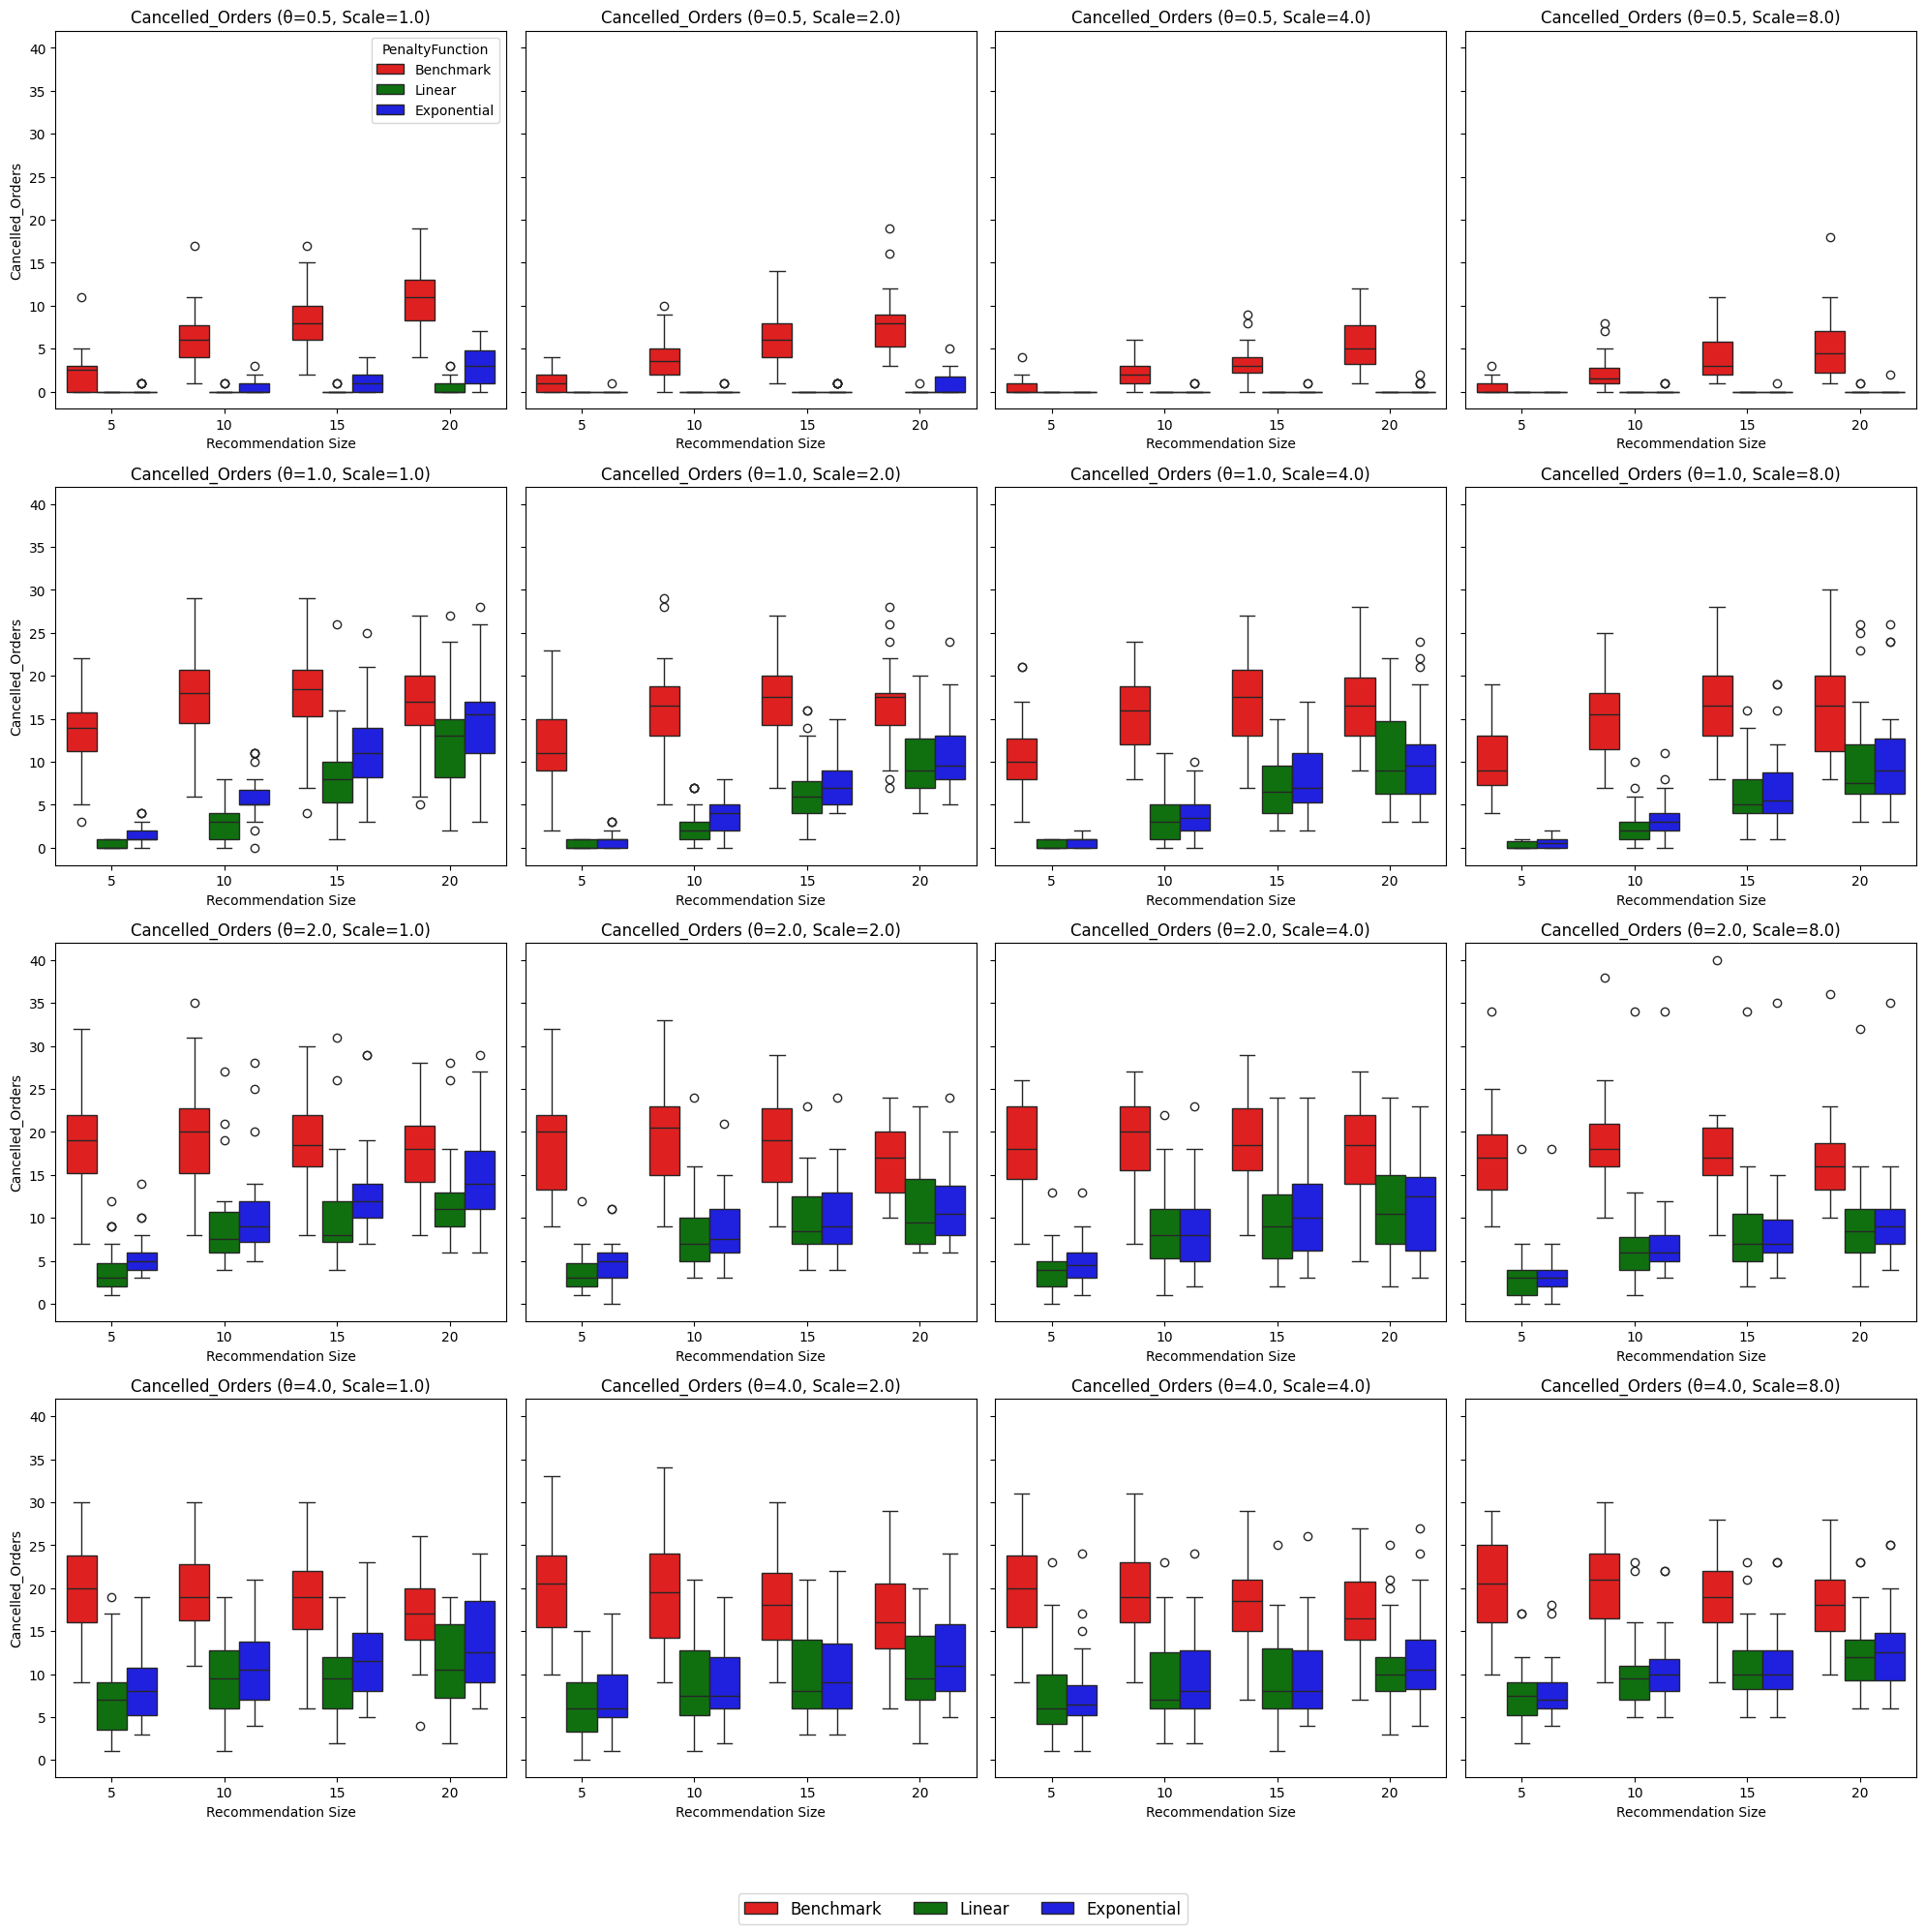

In [ ]:
colors = {
    "Benchmark": "red",
    "Linear": "green",
    "Exponential": "blue"
}

metrics = ["Revenue", "Waste_Percentage", "LeavingCustomers", "Cancelled_Orders"]

scenario = "Relatively Popular (α = 0.7)"


metric = "Cancelled_Orders"

unique_pairs = results_df[["Theta", "Scale"]].drop_duplicates().values
n_pairs = len(unique_pairs)

nrows, ncols = 4, 4

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharey=True)
axes = axes.flatten() if hasattr(axes, "flatten") else [axes]

for idx, (theta, scale) in enumerate(unique_pairs):
    ax = axes[idx]
    subset = subset = results_df[
    (results_df["Theta"] == theta) &
    (results_df["Scale"] == scale) &
    (results_df["Attractiveness"] == scenario)
]

    sns.boxplot(
        data=subset,
        x="Recommendation Size",
        y=metric,
        hue="PenaltyFunction",
        palette=colors,
        ax=ax
    )

    ax.set_title(f"{metric} (θ={theta}, Scale={scale})")
    ax.set_xlabel("Recommendation Size")
    ax.set_ylabel(metric)

    if idx != 0:
        ax.get_legend().remove()

# Remove any unused subplots
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [ ]:
Config.DAYS = 30
Config.THETA = 1
Config.SCALE = 1
# Config.attractiveness = 0.9
Config.CustomersVolume = 0.85

# Recom_sizes = [5,10,15,20]

# algorithms = {"Benchmark": penaltyBenchmark_,
#               "Linear": penaltyLinear_,
#               "Exponential": penaltyExp_}

# # print("Benchmark \n")
# runSumulationDiffSizes, TotalCustomerValuations = simulateDiffSizes_(days=Config.DAYS,
#                       recommendation_sizes=Recom_sizes,
#                       scalePar = Config.SCALE,
#                       thetaPar=Config.THETA,
#                       algorithmChoice=algorithms)

attractiveness_ = {
    "Less Popular (α = 0.6) ": 0.6,
    "Relatively Popular (α = 0.7) ": 0.7,
    "Highly Popular (α = 0.8) ": 0.8
}

attractivenessData = {}
Recom_sizes = [5, 10, 15, 20]

algorithms = {
    "Benchmark": penaltyBenchmark_,
    "Linear": penaltyLinear_,
    "Exponential": penaltyExp_
}

for label, attract in attractiveness_.items():
    Config.attractiveness = attract

    runSumulationDiffSizes, _ = simulateDiffSizes_(
        days=Config.DAYS,
        recommendation_sizes=Recom_sizes,
        scalePar=Config.SCALE,
        thetaPar=Config.THETA,
        algorithmChoice=algorithms
    )

    attractivenessData[label] = runSumulationDiffSizes

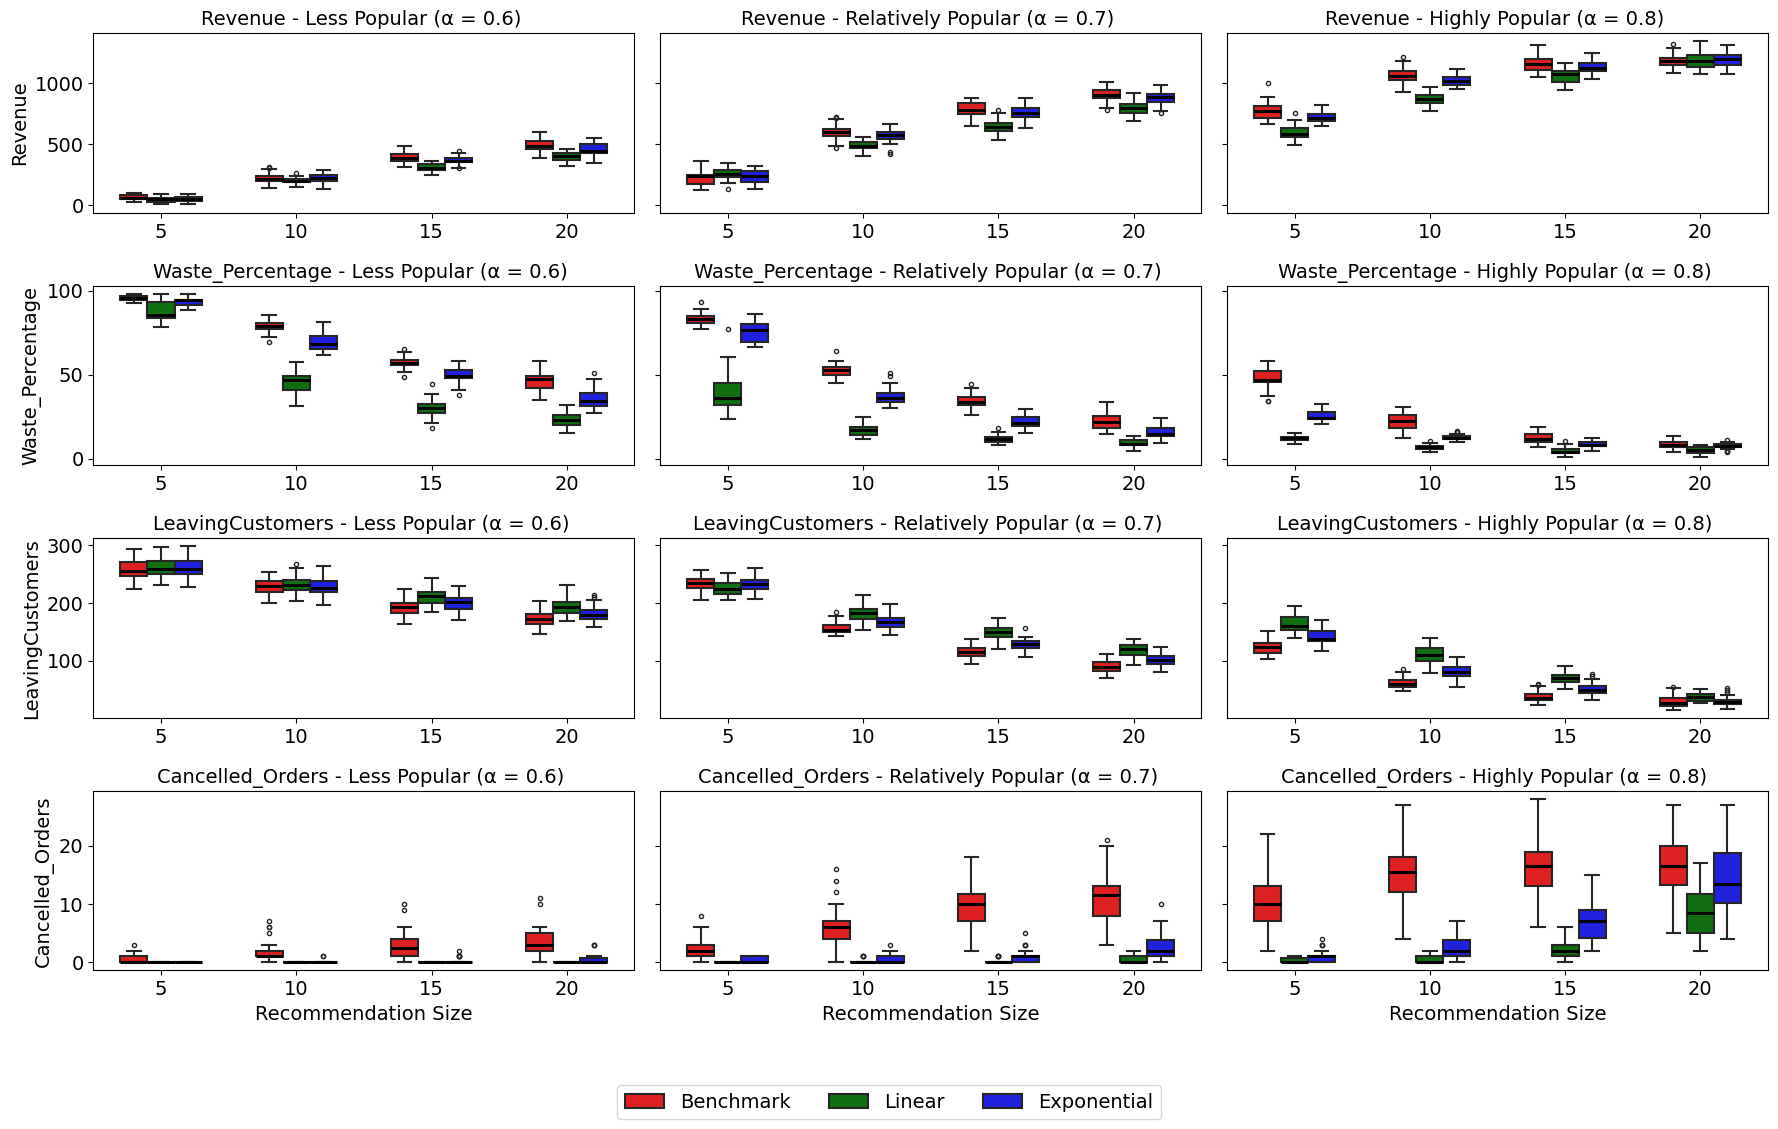

In [ ]:
all_data = []
Colorpalette = {"Benchmark": "red", "Linear": "green", "Exponential": "blue"}


for attractiveness_label, df in attractivenessData.items():
    df_copy = df.copy()
    df_copy['Attractiveness'] = attractiveness_label
    all_data.append(df_copy)

combined_df = pd.concat(all_data, ignore_index=True)

# Ensure key columns are in correct type for plotting
combined_df['Recommendation Size'] = combined_df['Recommendation Size'].astype(str)
combined_df['Algorithm'] = combined_df['Algorithm'].astype(str)
combined_df['Attractiveness'] = combined_df['Attractiveness'].astype(str)

# Select the metrics to plot
metrics = ['Revenue', 'Waste_Percentage', 'LeavingCustomers', 'Cancelled_Orders']

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

# Plotting
fig, axs = plt.subplots(len(metrics), len(attractiveness_), figsize=(18, 12), sharey='row')
# fig.suptitle('Comparison of Metrics Across Algorithms, Recommendation Sizes, and Traffic Scenarios', fontsize=16)

for i, metric in enumerate(metrics):
    for j, k in enumerate(attractiveness_.keys()):
        ax = axs[i, j]
        sns.boxplot(
            data=combined_df[combined_df['Attractiveness'] == k],
            x='Recommendation Size',
            y=metric,
            hue='Algorithm',
            ax=ax,
            palette=Colorpalette,
            width=0.6,
            linewidth=1.8,
            fliersize=3,
            medianprops={"color": "black", "linewidth": 2.2},
            whiskerprops={"linewidth": 1.5},
            capprops={"linewidth": 1.5},
            boxprops={"linewidth": 1.5}
        )
        ax.set_title(f'{metric} - {k}')
        ax.set_xlabel('') if i < len(metrics) - 1 else ax.set_xlabel('Recommendation Size')
        ax.set_ylabel(metric if j == 0 else '')
        ax.legend_.remove()


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(Colorpalette))

# fig.legend(handles, labels, loc='lower center', ncol=len(algorithms))
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

**Traffic**

In [ ]:
Config.attractiveness = 0.8
Theta_values = [0.5, 1, 2, 4]
Scale_values = [1, 2, 4, 8]

Recom_sizes = [5, 10, 15, 20]

algorithms = {
    "Benchmark": penaltyBenchmark_,
    "Linear": penaltyLinear_,
    "Exponential": penaltyExp_
}

traffic_ = {
    "Low traffic (ρ = 0.5)": 0.5,
    "Normal traffic (ρ = 0.8)": 0.8,
    "High traffic (ρ = 0.95)": 0.95,
}

results_traffic = {}

for theta in Theta_values:
    for scale in Scale_values:
        Config.THETA = theta
        Config.SCALE = scale

        key = (theta, scale)
        results_traffic[key] = {}

        for label, volume in traffic_.items():
            Config.CustomersVolume = volume

            runSimulationDiffSizes, _ = simulateDiffSizes_(
                days=Config.DAYS,
                recommendation_sizes=Recom_sizes,
                scalePar=Config.SCALE,
                thetaPar=Config.THETA,
                algorithmChoice=algorithms
            )

            results_traffic[key][label] = runSimulationDiffSizes

In [ ]:
all_ = []

for (theta, scale), data in results_traffic.items():
    for traffic_label, df in data.items():
        df_copy = df.copy()

        df_copy["Theta"] = theta
        df_copy["Scale"] = scale
        df_copy["Traffic"] = traffic_label

        df_copy = df_copy.rename(columns={"Algorithm": "PenaltyFunction"})

        all_.append(df_copy)

results_traffic_df = pd.concat(all_, ignore_index=True)

save_path = "/content/drive/MyDrive/Food Waste Project/Traffic_Results.csv"
results_traffic_df.to_csv(save_path, index=False)

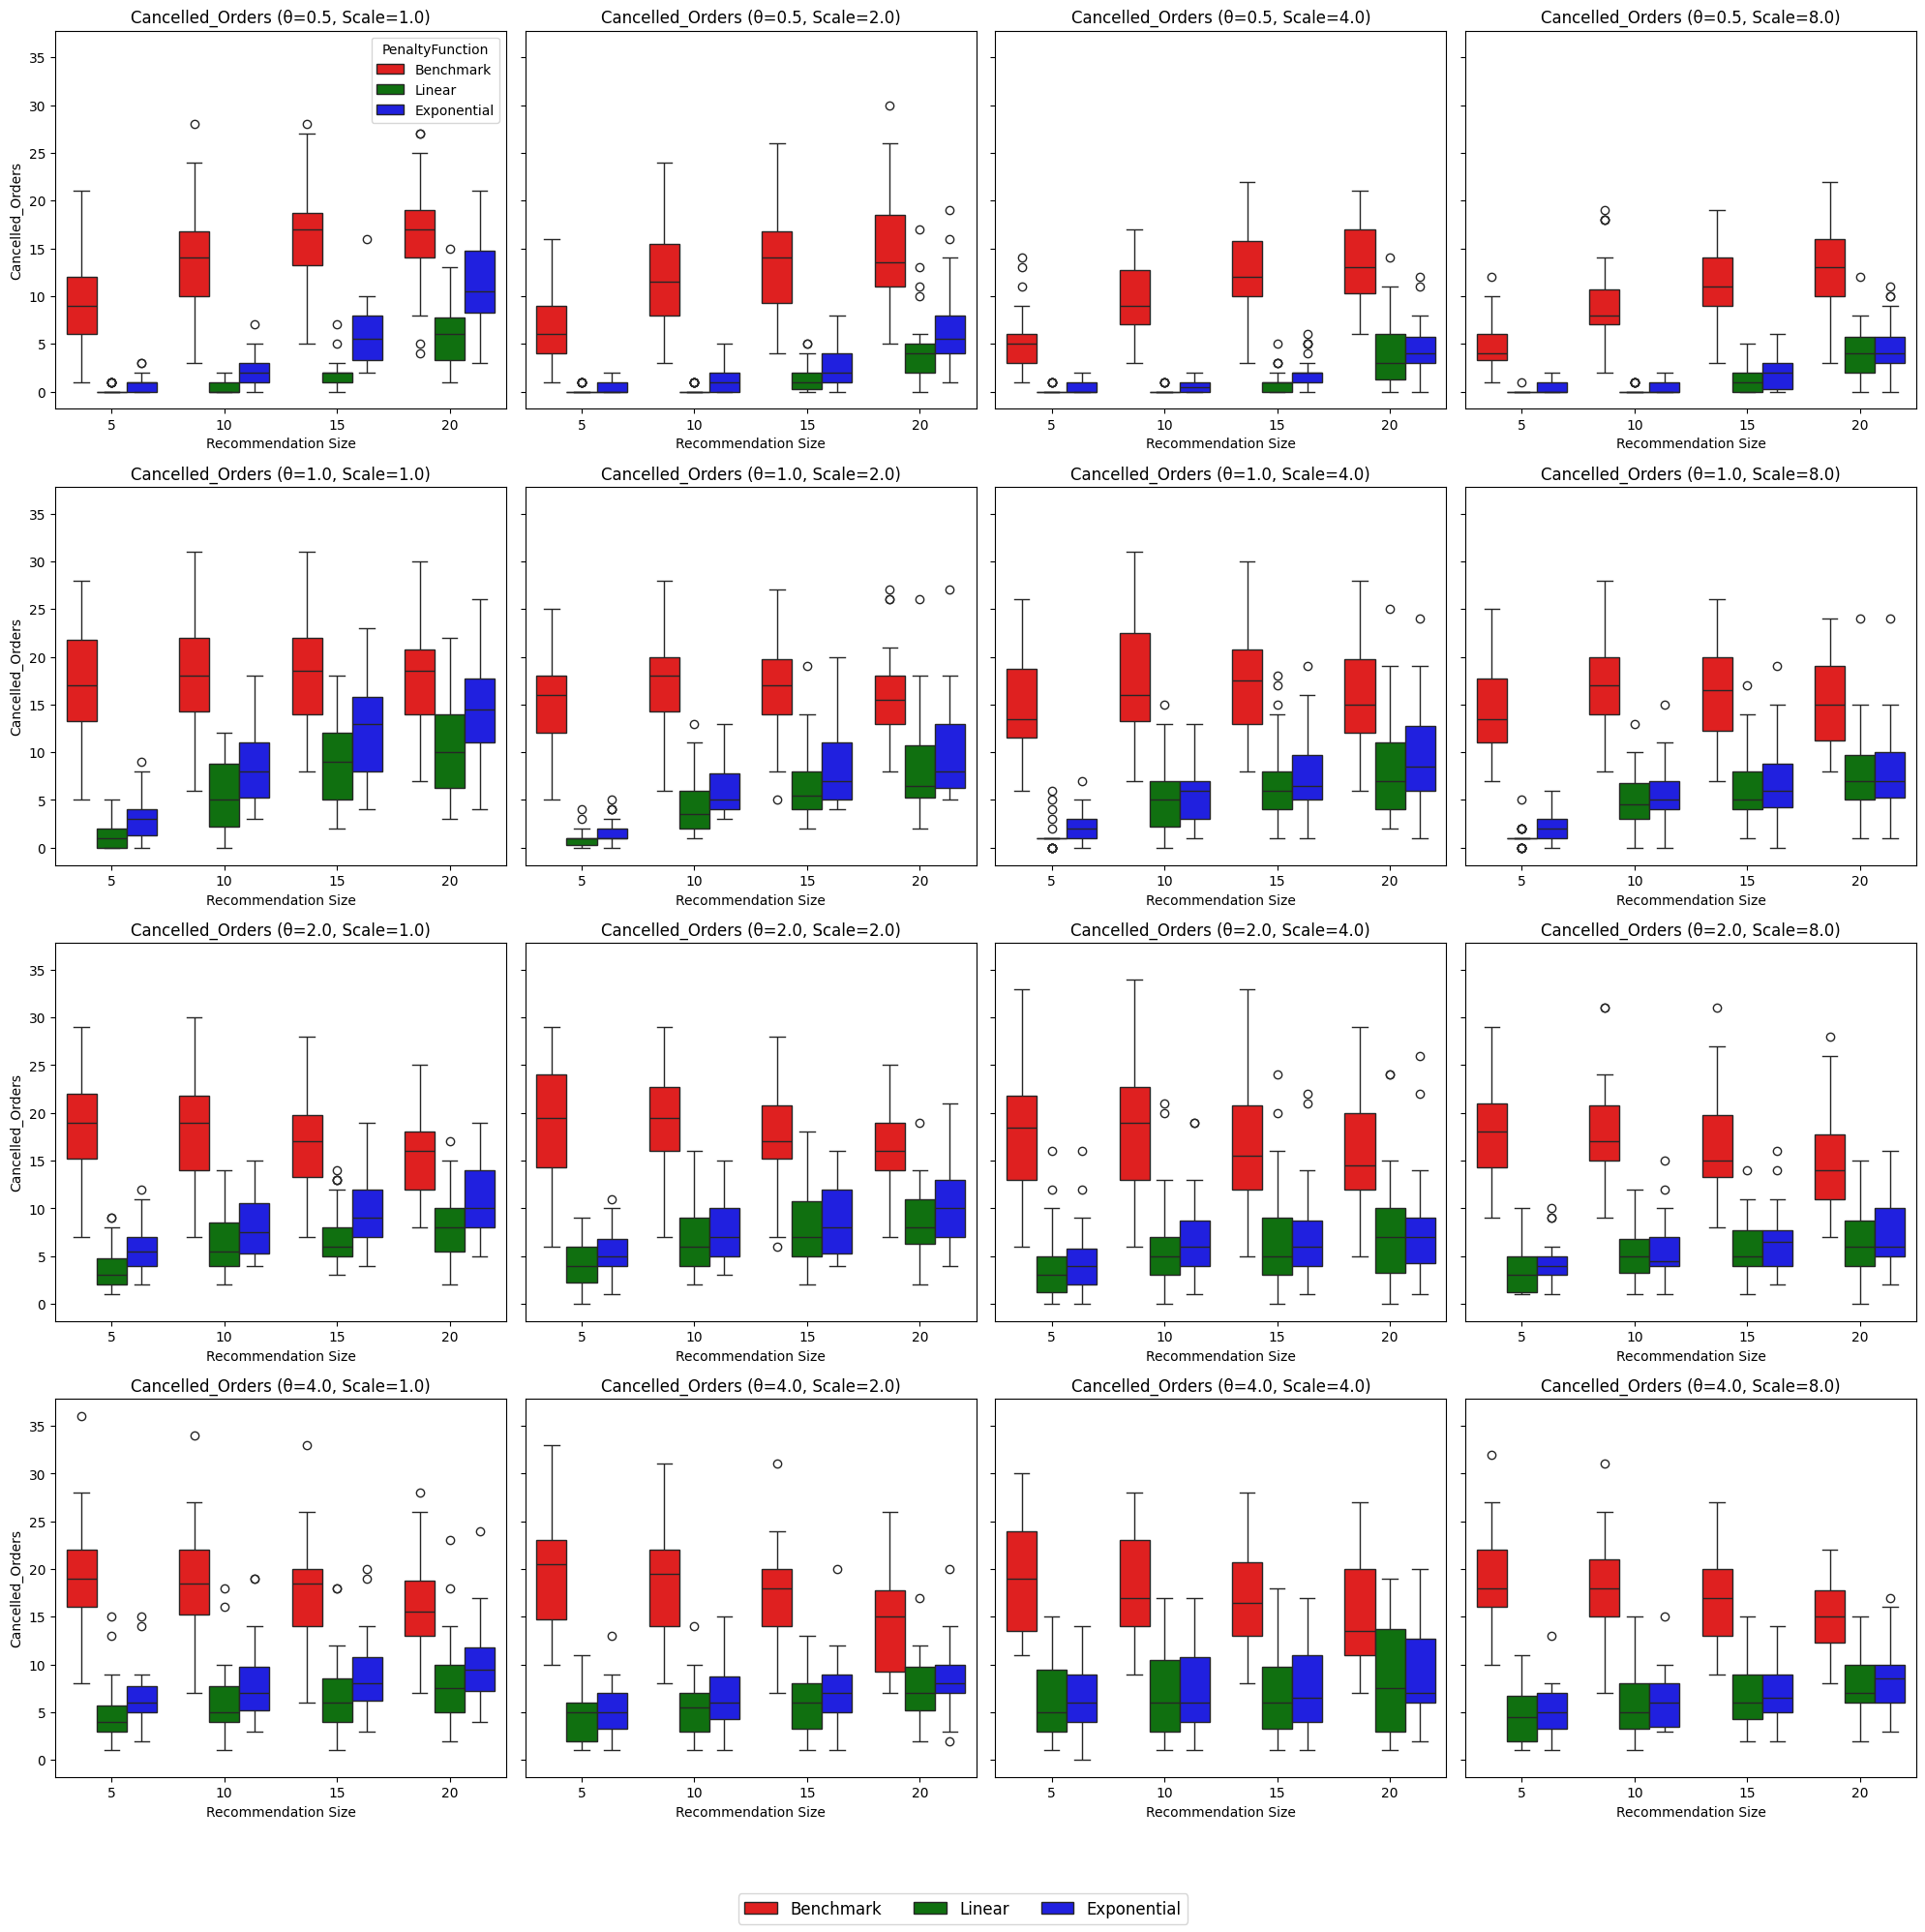

In [ ]:
colors = {
    "Benchmark": "red",
    "Linear": "green",
    "Exponential": "blue"
}

metrics = ["Revenue", "Waste_Percentage", "LeavingCustomers", "Cancelled_Orders"]

scenario = "Normal traffic (ρ = 0.8)"


metric = "Cancelled_Orders"

unique_pairs = results_traffic_df[["Theta", "Scale"]].drop_duplicates().values
n_pairs = len(unique_pairs)

nrows, ncols = 4, 4

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharey=True)
axes = axes.flatten() if hasattr(axes, "flatten") else [axes]

for idx, (theta, scale) in enumerate(unique_pairs):
    ax = axes[idx]
    subset = subset = results_traffic_df[
    (results_traffic_df["Theta"] == theta) &
    (results_traffic_df["Scale"] == scale) &
    (results_traffic_df["Traffic"] == scenario)
]

    sns.boxplot(
        data=subset,
        x="Recommendation Size",
        y=metric,
        hue="PenaltyFunction",
        palette=colors,
        ax=ax
    )

    ax.set_title(f"{metric} (θ={theta}, Scale={scale})")
    ax.set_xlabel("Recommendation Size")
    ax.set_ylabel(metric)

    if idx != 0:
        ax.get_legend().remove()

# Remove any unused subplots
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [ ]:
Config.THETA = 0.5
Config.SCALE = 1
Config.attractiveness = 0.8
# Config.CustomersVolume = 0.6

# Recom_sizes = [5,10,15,20]

# algorithms = {"Benchmark": penaltyBenchmark_,
#               "Linear": penaltyLinear_,
#               "Exponential": penaltyExp_}

# # print("Benchmark \n")
# runSumulationDiffSizes, TotalCustomerValuations = simulateDiffSizes_(days=Config.DAYS,
#                       recommendation_sizes=Recom_sizes,
#                       scalePar = Config.SCALE,
#                       thetaPar=Config.THETA,
#                       algorithmChoice=algorithms)

traffic_ = {
    "Low traffic (ρ = 0.5)": 0.5,
    "Normal traffic (ρ = 0.8)": 0.8,
    "High traffic (ρ = 0.95)": 0.95,
}

trafficData = {}
Recom_sizes = [5, 10, 15, 20]

algorithms = {
    "Benchmark": penaltyBenchmark_,
    "Linear": penaltyLinear_,
    "Exponential": penaltyExp_
}

for label, volume in traffic_.items():
    Config.CustomersVolume = volume

    runSumulationDiffSizes, _ = simulateDiffSizes_(
        days=Config.DAYS,
        recommendation_sizes=Recom_sizes,
        scalePar=Config.SCALE,
        thetaPar=Config.THETA,
        algorithmChoice=algorithms
    )

    trafficData[label] = runSumulationDiffSizes

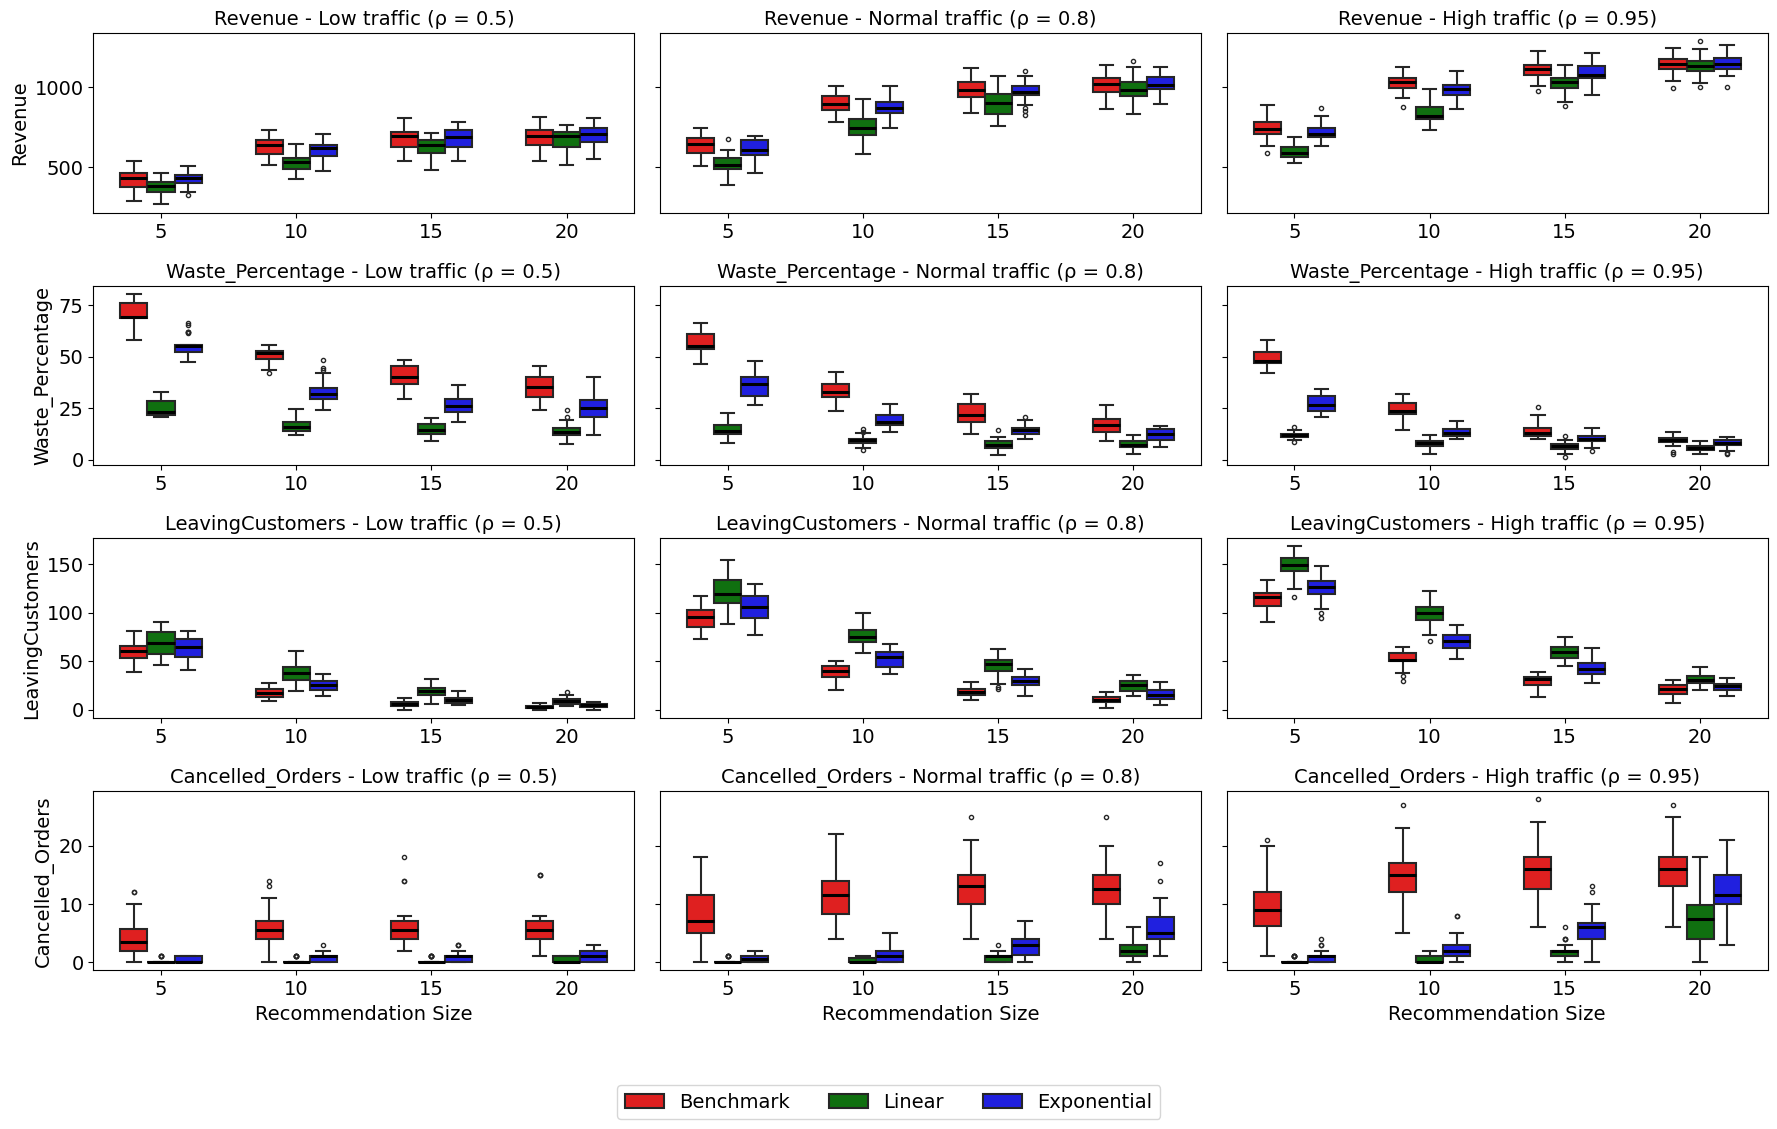

In [ ]:
all_data = []
Colorpalette = {"Benchmark": "red", "Linear": "green", "Exponential": "blue"}


for traffic_label, df in trafficData.items():
    df_copy = df.copy()
    df_copy['Traffic'] = traffic_label
    all_data.append(df_copy)

combined_df = pd.concat(all_data, ignore_index=True)

# Ensure key columns are in correct type for plotting
combined_df['Recommendation Size'] = combined_df['Recommendation Size'].astype(str)
combined_df['Algorithm'] = combined_df['Algorithm'].astype(str)
combined_df['Traffic'] = combined_df['Traffic'].astype(str)

# Select the metrics to plot
metrics = ['Revenue', 'Waste_Percentage', 'LeavingCustomers', 'Cancelled_Orders']

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

# Plotting
fig, axs = plt.subplots(len(metrics), len(traffic_), figsize=(18, 12), sharey='row')
# fig.suptitle('Comparison of Metrics Across Algorithms, Recommendation Sizes, and Traffic Scenarios', fontsize=16)

for i, metric in enumerate(metrics):
    for j, k in enumerate(traffic_.keys()):
        ax = axs[i, j]
        sns.boxplot(
            data=combined_df[combined_df['Traffic'] == k],
            x='Recommendation Size',
            y=metric,
            hue='Algorithm',
            ax=ax,
            palette=Colorpalette,
            width=0.6,
            linewidth=1.8,
            fliersize=3,
            medianprops={"color": "black", "linewidth": 2.2},
            whiskerprops={"linewidth": 1.5},
            capprops={"linewidth": 1.5},
            boxprops={"linewidth": 1.5}
        )
        ax.set_title(f'{metric} - {k}')
        ax.set_xlabel('') if i < len(metrics) - 1 else ax.set_xlabel('Recommendation Size')
        ax.set_ylabel(metric if j == 0 else '')
        ax.legend_.remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(Colorpalette))

# fig.legend(handles, labels, loc='lower center', ncol=len(algorithms))
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

## **Midday Waste Update**

In [ ]:
def simulateDiffSizes_(days, recommendation_sizes, scalePar, thetaPar, algorithmChoice):

    results = {alg_name: {size: [] for size in recommendation_sizes} for alg_name in algorithms}

    for day in range(1, days + 1):

        stores = stores_initialization()
        AVG_STORE_RATING = np.mean([store.storeRating for store in stores])

        for store in stores:
            multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scalePar))
            store.valuation = multiplier * store.bagPrice
            key = (store.storeID, day)
            if key in waste_dict:
                store.realizedWaste = waste_dict[key]

        # Calculate daily bags available and generate customer arrivals
        daily_bags_available = sum(store.bagsAvailable for store in stores)

        # Only generate customers if there are bags available
        if daily_bags_available > 0:
            customersRange = Config.CustomersVolume * daily_bags_available
            daily_arrivals, storesValuations = generate_customer_arrivals(stores, AVG_STORE_RATING, customersRange, scalePar, thetaPar)
            # print(f"Customers arrived: {len(daily_arrivals)}\n")

            customers = [
                Customer(
                    customerID=arrival['Customer ID'],
                    customerArrival=arrival['Arrival Time'],
                    status=False
                )
                for arrival in daily_arrivals
            ]

            TotalCustomerValuations = pd.DataFrame(storesValuations)

            # Simulate for each algorithm and recommendation size
            for alg_name, algorithmChoice in algorithms.items():
                for size in recommendation_sizes:

                    copyCustomers = copy.deepcopy(customers)
                    copyStores = copy.deepcopy(stores)

                    # Initialize end-of-day metrics
                    end_of_day = {
                        'Algorithm': alg_name,
                        'Day': day,
                        'Recommendation Size': size,
                        'Revenue': 0,
                        'SoldBags': 0,
                        'UnSoldBags': 0,
                        'LeavingCustomers': 0,
                        'BagsAvailable': daily_bags_available,
                        'Waste_Percentage': 0,
                        'Cancelled_Orders': 0,
                        'ZeroDemand_Stores': 0,
                        'Waste_to_Customer': []
                    }


                    # Process each customer
                    for customer in copyCustomers:
                        # print(f"Customer: {customer.customerID}")
                        recommendation_strategy = algorithmChoice(copyStores, size=size)
                        purchase_made = process_customers(customer, recommendation_strategy, daily_arrivals)

                        if purchase_made:
                            for store in copyStores:
                                if customer.customerChoice == store.storeID:
                                    end_of_day['Revenue'] += store.bagPrice
                                    end_of_day['SoldBags'] += 1
                        else:
                            end_of_day['LeavingCustomers'] += 1

                    # Calculate waste and other metrics
                    for store in copyStores:
                        if store.demand >= store.realizedWaste:
                            store.CancelledOrders = store.demand - store.realizedWaste
                            end_of_day['Cancelled_Orders'] += store.CancelledOrders
                            end_of_day['Revenue'] -= store.CancelledOrders * store.bagPrice
                            store.remainingBags = 0
                            end_of_day['Waste_to_Customer'].append(1)

                        if store.demand < store.realizedWaste and store.demand != 0:
                            waste_to_customer = store.realizedWaste / store.demand
                            end_of_day['Waste_to_Customer'].append(waste_to_customer)
                            store.remainingBags = 0

                        if store.demand == 0:
                            end_of_day['ZeroDemand_Stores'] += 1

                    # Calculate unsold bags
                    end_of_day['UnSoldBags'] = sum(store.remainingBags for store in copyStores)
                    if daily_bags_available > 0:
                        end_of_day['Waste_Percentage'] = (end_of_day['UnSoldBags'] / daily_bags_available) * 100

                    # Append the results for this algorithm and recommendation size
                    results[alg_name][size].append(end_of_day)
        else:
             # If no bags available, record zero metrics for all algorithms and sizes
            for alg_name in algorithms:
                for size in recommendation_sizes:
                     end_of_day = {
                        'Algorithm': alg_name,
                        'Day': day,
                        'Recommendation Size': size,
                        'Revenue': 0,
                        'SoldBags': 0,
                        'UnSoldBags': 0,
                        'LeavingCustomers': 0,
                        'BagsAvailable': 0,
                        'Waste_Percentage': 0,
                        'Cancelled_Orders': 0,
                        'ZeroDemand_Stores': 0,
                        'Waste_to_Customer': []
                    }
                     results[alg_name][size].append(end_of_day)

    # Convert results to DataFrames
    data_frames = []
    for alg_name, size_data in results.items():
        for size, metrics in size_data.items():
            df = pd.DataFrame(metrics)
            df['Algorithm'] = alg_name
            df['Recommendation Size'] = size
            data_frames.append(df)

    return pd.concat(data_frames, ignore_index=True), TotalCustomerValuations

# **METRICS TO TRACK**

In [ ]:
THETA_VALUES  = [0.5, 1]
SCALE_VALUES = [1, 2]

traffic_ = {"Low": 0.4, "Normal": 1.0, "High": 1.5, "Busy": 2.0}
attractiveness_ = {"Low": 0.6, "Normal": 0.7, "High": 0.8}

Recom_sizes = [5, 10]

algorithms = {
    "Benchmark": penaltyBenchmark_,
    "Linear":    penaltyLinear_,
    "Exponential": penaltyExp_,
}

METRICS = ['Revenue', 'Waste_Percentage', 'LeavingCustomers', 'Cancelled_Orders']

# **RUN SIMULATION**

In [ ]:
def SIM_RUNS(theta, scale, traffic_val, attractiveness_val, traffic_label, attractiveness_label):

    Config.THETA = theta
    Config.SCALE = scale

    Config.CustomersVolume = traffic_val
    Config.attractiveness = attractiveness_val

    sim_data, _ = simulateDiffSizes_(
        days=Config.DAYS,
        recommendation_sizes=Recom_sizes,
        scalePar=Config.SCALE,
        thetaPar=Config.THETA,
        algorithmChoice=algorithms
    )

    sim_data = sim_data.copy()
    sim_data["theta"]         = theta
    sim_data["scale"]         = scale
    sim_data["traffic"]       = traffic_label
    sim_data["attractiveness"] = attractiveness_label

    return sim_data

In [ ]:
def helper_(sim_data):

    df = sim_data.copy()

    # Metrices
    metrices_col = ["Algorithm", "RecommendationSize", "Day", "theta", "scale", "traffic", "attractiveness"]

    exploded = False

    for c in METRICS:
        if c in df.columns and df[c].apply(lambda x: isinstance(x, (list, tuple, np.ndarray))).any():
            df = df.explode(c).rename(columns={c: c})
            exploded = True

    if exploded and "Day" not in df.columns:
        df["Day"] = df.groupby(["Algorithm", "RecommendationSize"]).cumcount() + 1

    keep_cols = [c for c in metrices_col if c in df.columns] + [m for m in METRICS if m in df.columns]
    df = df[keep_cols]

    if "Day" not in df.columns:
        df["Day"] = 1

    All_DATA = df.melt(
        id_vars=[c for c in ["Algorithm","RecommendationSize","Day","theta","scale","traffic","attractiveness"] if c in df.columns],
        value_vars=[m for m in METRICS if m in df.columns],
        var_name="Metric",
        value_name="Value"
    )

    All_DATA["Value"] = pd.to_numeric(All_DATA["Value"], errors="coerce")

    return All_DATA


In [ ]:
fixed_traffic = ('Normal', traffic_['Normal'])
fixed_scale = SCALE_VALUES[0]

RUN_ALL_theta_attr = []

for alabel, aval in attractiveness_.items():
    for t in THETA_VALUES:
        sim_data = SIM_RUNS(
            theta=t,
            scale=fixed_scale,
            traffic_val=fixed_traffic[1],
            attractiveness_val=aval,
            traffic_label=fixed_traffic[0],
            attractiveness_label=alabel
        )
        ALL_DATA = helper_(sim_data)
        RUN_ALL_theta_attr.append(ALL_DATA)

df_theta_attr = pd.concat(RUN_ALL_theta_attr, ignore_index=True)

In [ ]:
print(df_theta_attr.head())

   Algorithm  Day  theta  scale traffic attractiveness   Metric  Value
0  Benchmark    1    0.5      1  Normal            Low  Revenue  79.58
1  Benchmark    2    0.5      1  Normal            Low  Revenue  50.42
2  Benchmark    3    0.5      1  Normal            Low  Revenue  36.94
3  Benchmark    4    0.5      1  Normal            Low  Revenue  61.91
4  Benchmark    5    0.5      1  Normal            Low  Revenue  81.38


In [ ]:
RUN_ALL = []

for tlabel, tval in traffic_.items():
    for alabel, aval in attractiveness_.items():
        for t in THETA_VALUES:
            for s in SCALE_VALUES:

                sim_data = SIM_RUNS(
                    theta=t,
                    scale=s,
                    traffic_val = tval,
                    attractiveness_val = aval,
                    traffic_label = tlabel,
                    attractiveness_label= alabel
                )

                ALL_DATA = helper_(sim_data)
                RUN_ALL.append(ALL_DATA)

results = pd.concat(RUN_ALL, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
def plot_metric_grid(df, metric, attract="Normal", figsize=(14, 10)):
    d = df[(df["Metric"] == metric) & (df["attractiveness"] == attract)].copy()
    if d.empty:
        print(f"No data for metric '{metric}' at attractiveness={attract}.")
        return

    traffic_levels = list(d["traffic"].unique())
    theta_scale_pairs = sorted(d[["theta","scale"]].drop_duplicates().itertuples(index=False, name=None))

    nrows = len(traffic_levels)
    ncols = len(theta_scale_pairs)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)

    grouped = (d.groupby(["traffic","theta","scale","Algorithm","RecommendationSize"], as_index=False)["Value"]
                .mean())

    for r, traffic in enumerate(traffic_levels):
        for c, (th, sc) in enumerate(theta_scale_pairs):
            ax = axes[r][c]
            sub = grouped[(grouped["traffic"] == traffic) &
                          (grouped["theta"] == th) &
                          (grouped["scale"] == sc)]
            if sub.empty:
                ax.set_axis_off()
                continue

            for alg, g in sub.groupby("Algorithm"):
                g = g.sort_values("RecommendationSize")
                ax.plot(g["RecommendationSize"], g["Value"], marker="o", label=alg)

            ax.set_title(f"{traffic} | θ={th}, s={sc}")
            ax.set_xlabel("Rec Size")
            ax.set_ylabel(metric)
            if r == 0 and c == 0:
                ax.legend(frameon=False)

    fig.suptitle(f"{metric} | Attractiveness={attract}", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# Example: show Revenue curves at Normal attractiveness
plot_metric_grid(results, "Revenue", attract="Normal")


In [ ]:
Config.DAYS = 30
Config.THETA = 0.5
Config.SCALE = 1
# Config.attractiveness = 0.9
Config.CustomersVolume = 1

# Recom_sizes = [5,10,15,20]

# algorithms = {"Benchmark": penaltyBenchmark_,
#               "Linear": penaltyLinear_,
#               "Exponential": penaltyExp_}

# # print("Benchmark \n")
# runSumulationDiffSizes, TotalCustomerValuations = simulateDiffSizes_(days=Config.DAYS,
#                       recommendation_sizes=Recom_sizes,
#                       scalePar = Config.SCALE,
#                       thetaPar=Config.THETA,
#                       algorithmChoice=algorithms)

attractiveness_ = {
    "Low": 0.6,
    "Normal": 0.7,
    "High": 0.8
}

attractivenessData = {}
Recom_sizes = [5, 10, 15, 20]

algorithms = {
    "Benchmark": penaltyBenchmark_,
    "Linear": penaltyLinear_,
    "Exponential": penaltyExp_
}

for label, attract in attractiveness_.items():
    Config.attractiveness = attract

    runSumulationDiffSizes, _ = simulateDiffSizes_(
        days=Config.DAYS,
        recommendation_sizes=Recom_sizes,
        scalePar=Config.SCALE,
        thetaPar=Config.THETA,
        algorithmChoice=algorithms
    )

    attractivenessData[label] = runSumulationDiffSizes

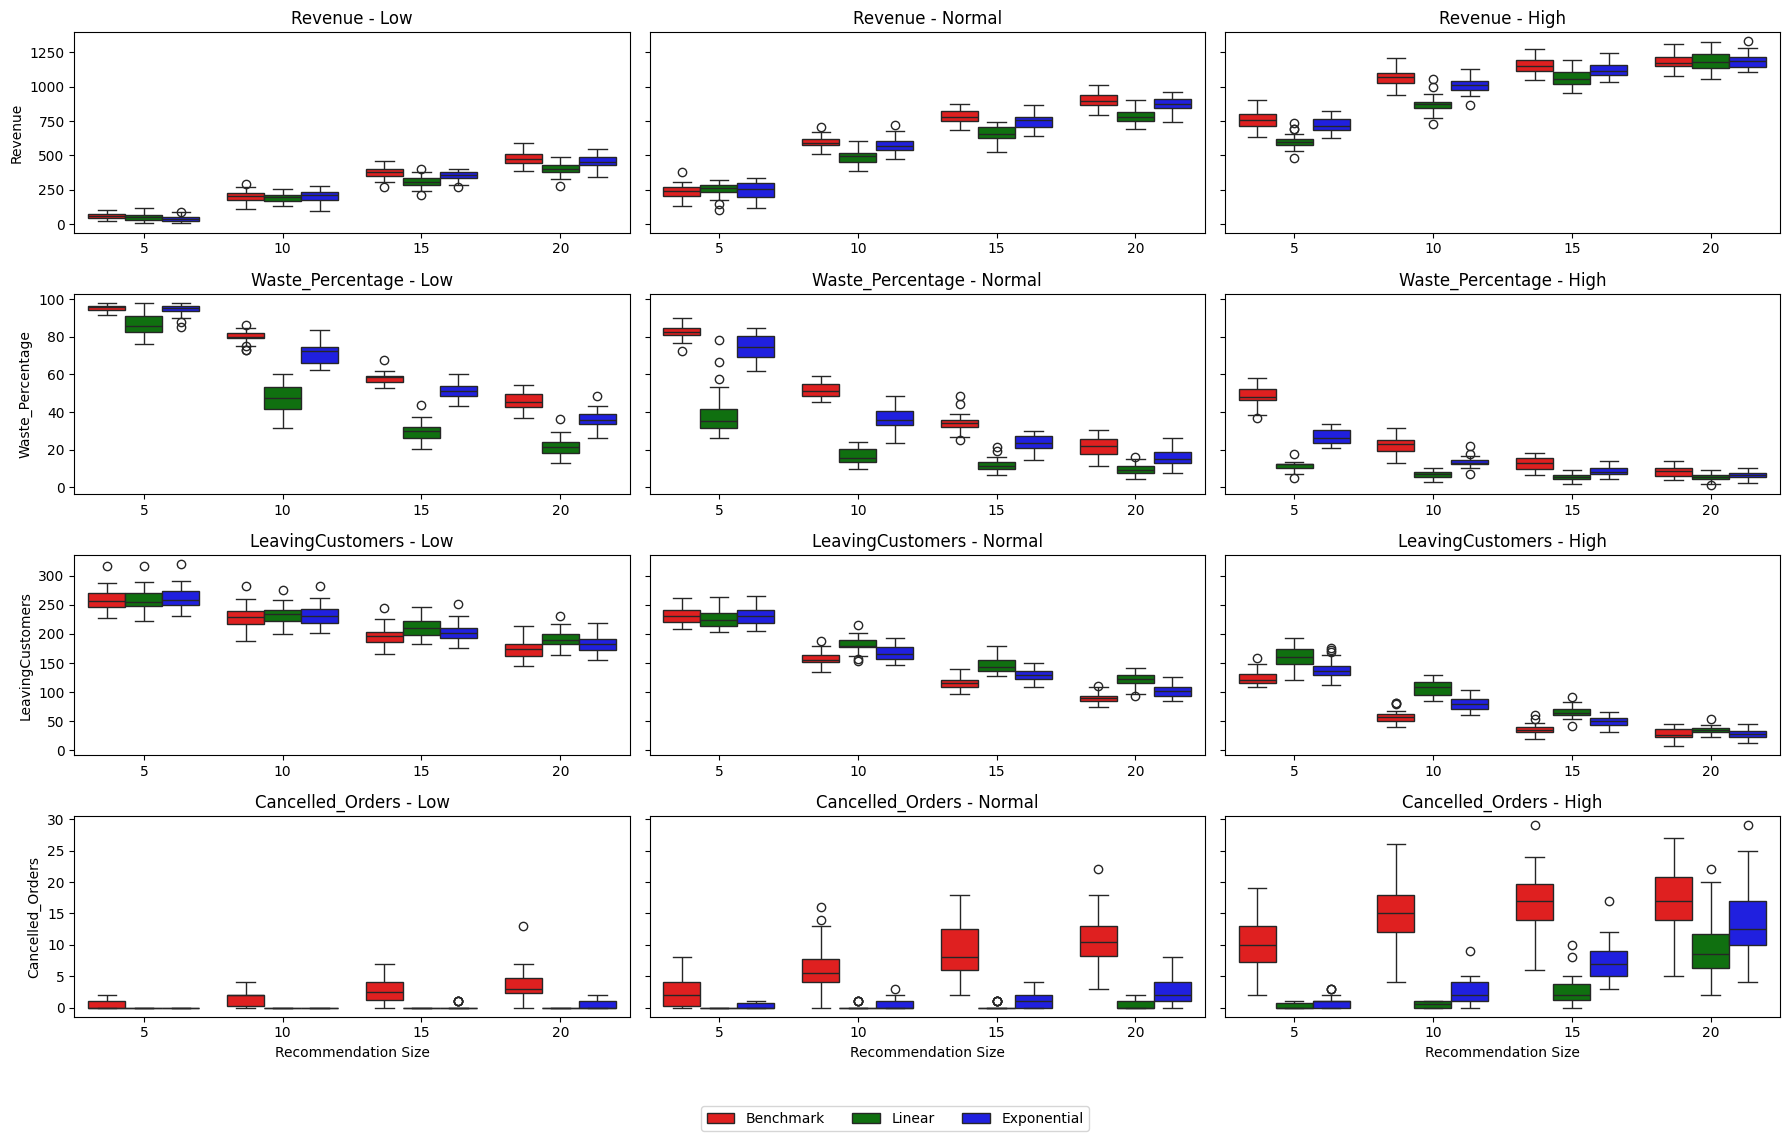

In [ ]:
all_data = []
Colorpalette = {"Benchmark": "red", "Linear": "green", "Exponential": "blue"}


for attractiveness_label, df in attractivenessData.items():
    df_copy = df.copy()
    df_copy['Attractiveness'] = attractiveness_label
    all_data.append(df_copy)

combined_df = pd.concat(all_data, ignore_index=True)

# Ensure key columns are in correct type for plotting
combined_df['Recommendation Size'] = combined_df['Recommendation Size'].astype(str)
combined_df['Algorithm'] = combined_df['Algorithm'].astype(str)
combined_df['Attractiveness'] = combined_df['Attractiveness'].astype(str)

# Select the metrics to plot
metrics = ['Revenue', 'Waste_Percentage', 'LeavingCustomers', 'Cancelled_Orders']

# Plotting
fig, axs = plt.subplots(len(metrics), len(attractiveness_), figsize=(18, 12), sharey='row')
# fig.suptitle('Comparison of Metrics Across Algorithms, Recommendation Sizes, and Traffic Scenarios', fontsize=16)

for i, metric in enumerate(metrics):
    for j, k in enumerate(attractiveness_.keys()):
        ax = axs[i, j]
        sns.boxplot(
            data=combined_df[combined_df['Attractiveness'] == k],
            x='Recommendation Size',
            y=metric,
            hue='Algorithm',
            ax=ax,
            palette=Colorpalette
        )
        ax.set_title(f'{metric} - {k}')
        ax.set_xlabel('') if i < len(metrics) - 1 else ax.set_xlabel('Recommendation Size')
        ax.set_ylabel(metric if j == 0 else '')
        ax.legend_.remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(algorithms))
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [ ]:
Config.THETA = 0.5
Config.SCALE = 1
Config.attractiveness = 0.9
# Config.CustomersVolume = 0.6

# Recom_sizes = [5,10,15,20]

# algorithms = {"Benchmark": penaltyBenchmark_,
#               "Linear": penaltyLinear_,
#               "Exponential": penaltyExp_}

# # print("Benchmark \n")
# runSumulationDiffSizes, TotalCustomerValuations = simulateDiffSizes_(days=Config.DAYS,
#                       recommendation_sizes=Recom_sizes,
#                       scalePar = Config.SCALE,
#                       thetaPar=Config.THETA,
#                       algorithmChoice=algorithms)

traffic_ = {
    "Low": 0.4,
    "Normal": 1.0,
    "High": 1.5,
    "Busy": 2.0
}

trafficData = {}
Recom_sizes = [5, 10, 15, 20]

algorithms = {
    "Benchmark": penaltyBenchmark_,
    "Linear": penaltyLinear_,
    "Exponential": penaltyExp_
}

for label, volume in traffic_.items():
    Config.CustomersVolume = volume

    runSumulationDiffSizes, _ = simulateDiffSizes_(
        days=Config.DAYS,
        recommendation_sizes=Recom_sizes,
        scalePar=Config.SCALE,
        thetaPar=Config.THETA,
        algorithmChoice=algorithms
    )

    trafficData[label] = runSumulationDiffSizes

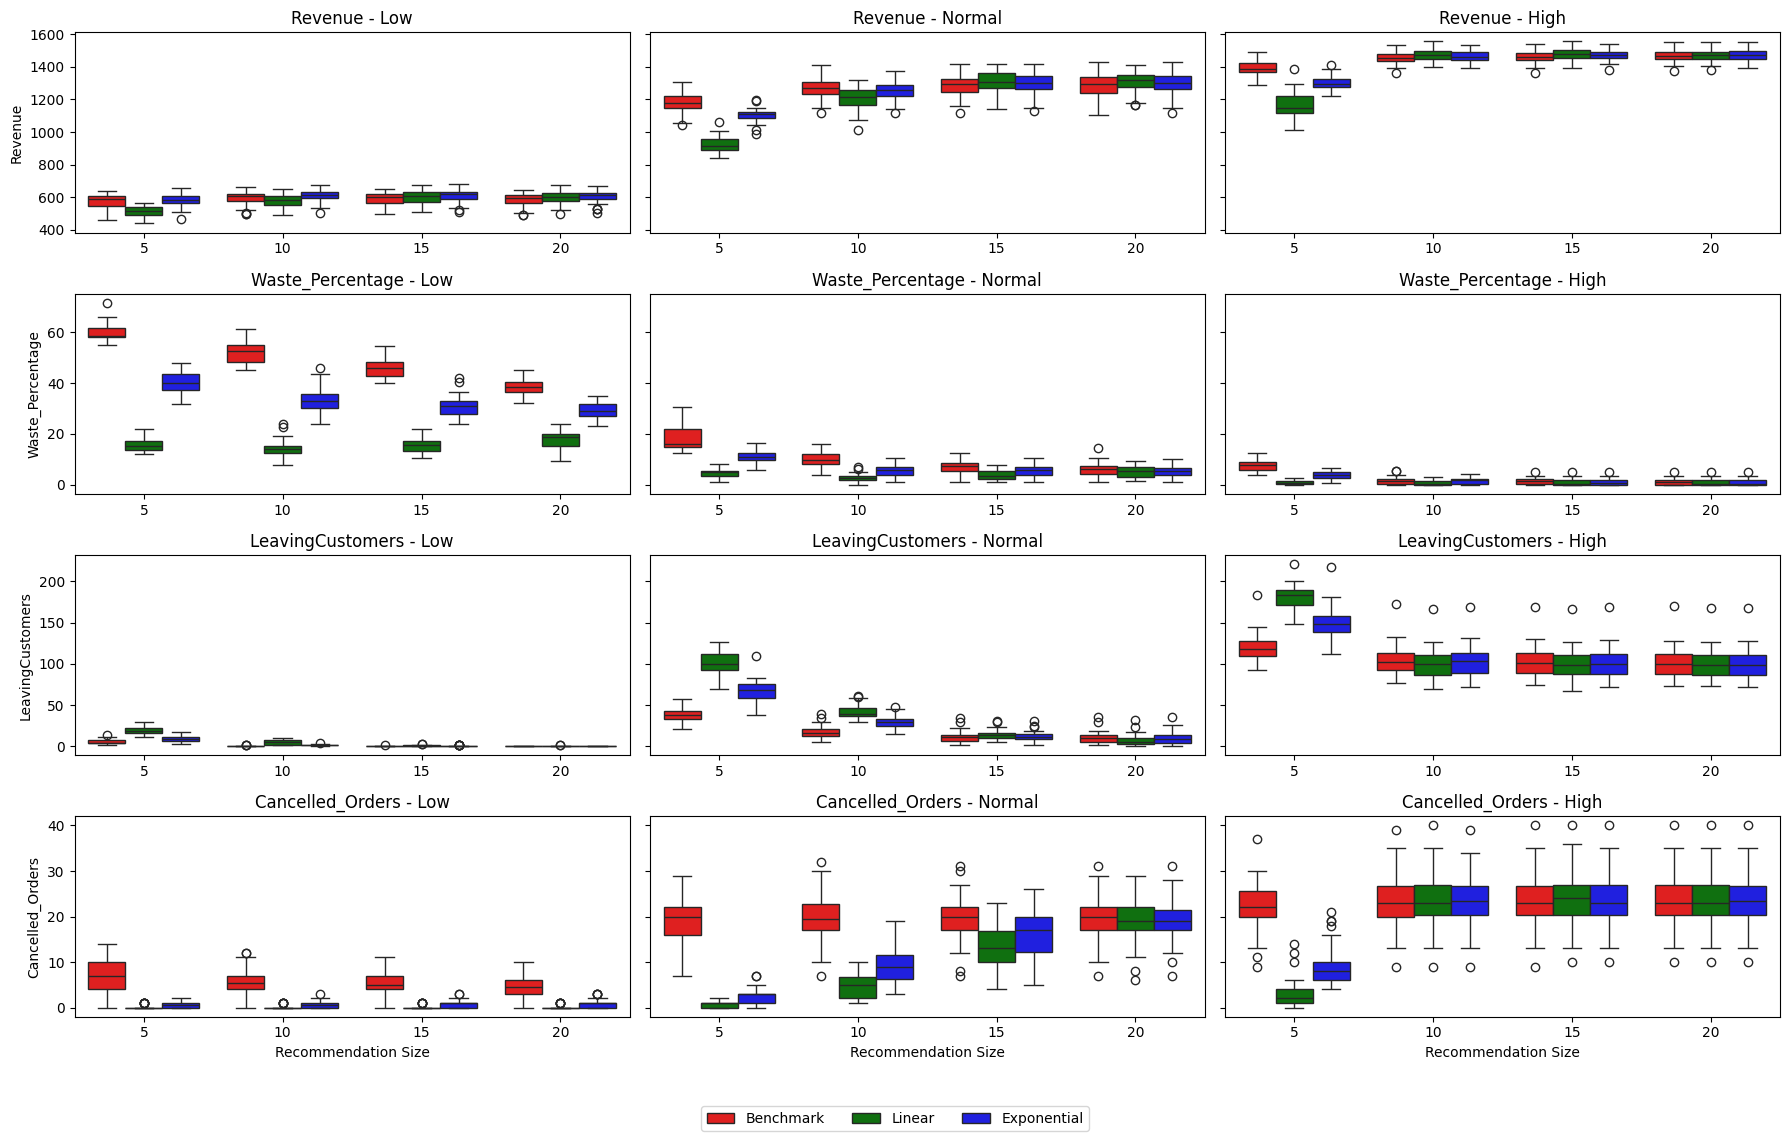

In [ ]:
all_data = []
Colorpalette = {"Benchmark": "red", "Linear": "green", "Exponential": "blue"}


for traffic_label, df in trafficData.items():
    df_copy = df.copy()
    df_copy['Traffic'] = traffic_label
    all_data.append(df_copy)

combined_df = pd.concat(all_data, ignore_index=True)

# Ensure key columns are in correct type for plotting
combined_df['Recommendation Size'] = combined_df['Recommendation Size'].astype(str)
combined_df['Algorithm'] = combined_df['Algorithm'].astype(str)
combined_df['Traffic'] = combined_df['Traffic'].astype(str)

# Select the metrics to plot
metrics = ['Revenue', 'Waste_Percentage', 'LeavingCustomers', 'Cancelled_Orders']

# Plotting
fig, axs = plt.subplots(len(metrics), len(attractiveness_), figsize=(18, 12), sharey='row')
# fig.suptitle('Comparison of Metrics Across Algorithms, Recommendation Sizes, and Traffic Scenarios', fontsize=16)

for i, metric in enumerate(metrics):
    for j, k in enumerate(attractiveness_.keys()):
        ax = axs[i, j]
        sns.boxplot(
            data=combined_df[combined_df['Traffic'] == k],
            x='Recommendation Size',
            y=metric,
            hue='Algorithm',
            ax=ax,
            palette=Colorpalette
        )
        ax.set_title(f'{metric} - {k}')
        ax.set_xlabel('') if i < len(metrics) - 1 else ax.set_xlabel('Recommendation Size')
        ax.set_ylabel(metric if j == 0 else '')
        ax.legend_.remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(algorithms))
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

<ipython-input-47-5104188f0f26>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exploded_df['WasteToCustomerRatio'].replace([np.inf, -np.inf], np.nan), errors='coerce'
<ipython-input-47-5104188f0f26>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = exploded_df.groupby(['Algorithm', 'Recommendation Size'], group_keys=False).apply(iqr_filter)


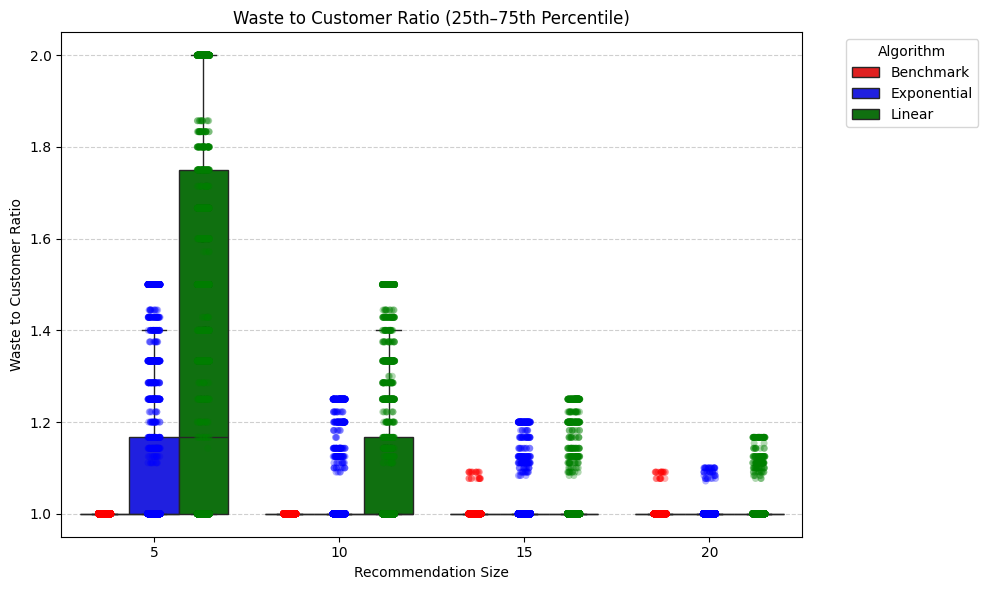

In [ ]:
Colorpalette = {"Benchmark": "red", "Linear": "green", "Exponential": "blue"}

runSumulationDiffSizes['Waste_to_Customer'] = runSumulationDiffSizes['Waste_to_Customer'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

exploded_df = (
    runSumulationDiffSizes.explode('Waste_to_Customer')
    .rename(columns={'Waste_to_Customer': 'WasteToCustomerRatio'})
    .reset_index(drop=True)
)

exploded_df['WasteToCustomerRatio'] = pd.to_numeric(
    exploded_df['WasteToCustomerRatio'].replace([np.inf, -np.inf], np.nan), errors='coerce'
)

def iqr_filter(group):
    q1 = group['WasteToCustomerRatio'].quantile(0.25)
    q3 = group['WasteToCustomerRatio'].quantile(0.75)
    return group[(group['WasteToCustomerRatio'] >= q1) & (group['WasteToCustomerRatio'] <= q3)]

filtered_df = exploded_df.groupby(['Algorithm', 'Recommendation Size'], group_keys=False).apply(iqr_filter)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_df,
    x='Recommendation Size',
    y='WasteToCustomerRatio',
    hue='Algorithm',
    palette=Colorpalette,
    showfliers=False
)

sns.stripplot(
    data=filtered_df,
    x='Recommendation Size',
    y='WasteToCustomerRatio',
    hue='Algorithm',
    dodge=True,
    alpha=0.3,
    jitter=True,
    palette=Colorpalette,
    legend=False
)

plt.title('Waste to Customer Ratio (25th–75th Percentile)')
plt.xlabel('Recommendation Size')
plt.ylabel('Waste to Customer Ratio')
plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## **Dual-Strategies**

In [ ]:
def simulateDual_(days, recommendation_sizes, scalePar, thetaPar):

    results = {size: [] for size in recommendation_sizes}

    for day in range(1, days + 1):
        stores = stores_initialization()
        AVG_STORE_RATING = np.mean([store.storeRating for store in stores])

        for store in stores:
            multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scalePar))
            store.valuation = multiplier * store.bagPrice
            key = (store.storeID, day)
            if key in waste_dict:
                store.realizedWaste = waste_dict[key]

        daily_bags_available = sum(store.bagsAvailable for store in stores)
        customersRange = 0.85 * daily_bags_available
        daily_arrivals, storesValuations = generate_customer_arrivals(
            stores, AVG_STORE_RATING, customersRange, scalePar, thetaPar
        )

        customers = [
            Customer(
                customerID=arrival['Customer ID'],
                customerArrival=arrival['Arrival Time'],
                status=False
            )
            for arrival in daily_arrivals
        ]

        TotalCustomerValuations = pd.DataFrame(storesValuations)

        for size in recommendation_sizes:
            copyCustomers = copy.deepcopy(customers)
            copyStores = copy.deepcopy(stores)

            end_of_day = {
                'Day': day,
                'Recommendation Size': size,
                'Revenue': 0,
                'SoldBags': 0,
                'UnSoldBags': 0,
                'LeavingCustomers': 0,
                'BagsAvailable': daily_bags_available,
                'Percentage_UnsoldBags': 0,
                'Cancelled_Orders': 0,
                'ZeroDemand_Stores': 0,
                'Waste_to_Customer': []
            }

            for customer in copyCustomers:
                if customer.customerArrival <= 12:
                    recommendation_strategy = penaltyBenchmark_(copyStores, size=size)
                else:
                    recommendation_strategy = penaltyExp_(copyStores, size=size)

                purchase_made = process_customers(customer, recommendation_strategy, daily_arrivals)

                if purchase_made:
                    for store in copyStores:
                        if customer.customerChoice == store.storeID:
                            end_of_day['Revenue'] += store.bagPrice
                            end_of_day['SoldBags'] += 1
                else:
                    end_of_day['LeavingCustomers'] += 1

            for store in copyStores:
                if store.demand >= store.realizedWaste:
                    store.CancelledOrders = store.demand - store.realizedWaste
                    end_of_day['Cancelled_Orders'] += store.CancelledOrders
                    end_of_day['Revenue'] -= store.CancelledOrders * store.bagPrice
                    store.remainingBags = 0
                    end_of_day['Waste_to_Customer'].append(1)

                elif store.demand < store.realizedWaste and store.demand != 0:
                    waste_to_customer = store.realizedWaste / store.demand
                    end_of_day['Waste_to_Customer'].append(waste_to_customer)
                    store.remainingBags = 0

                if store.demand == 0:
                    end_of_day['ZeroDemand_Stores'] += 1

            end_of_day['UnSoldBags'] = sum(store.remainingBags for store in copyStores)
            if daily_bags_available > 0:
                end_of_day['Percentage_UnsoldBags'] = (end_of_day['UnSoldBags'] / daily_bags_available) * 100

            results[size].append(end_of_day)

    # Convert to DataFrame
    data_frames = []
    for size, metrics in results.items():
        df = pd.DataFrame(metrics)
        df['Recommendation Size'] = size
        data_frames.append(df)

    return pd.concat(data_frames, ignore_index=True), TotalCustomerValuations

In [ ]:
Config.THETA = 0.5
Config.SCALE = 1
Config.attractiveness = 0.9
Config.CustomersVolume = 1

Recom_sizes = [5,10,15,20]

# algorithms = {"Benchmark": penaltyBenchmark_,
#               "Linear": penaltyLinear_,
#               "Exponential": penaltyExp_}

# print("Benchmark \n")

runSumulationDual, CustomerValuations = simulateDual_(days=Config.DAYS,
                      recommendation_sizes=Recom_sizes,
                      scalePar = Config.SCALE,
                      thetaPar=Config.THETA )

# drive_pathV = "/content/drive/MyDrive/Food Waste Project/TotalCustomerValuations.csv"
# TotalCustomerValuations.to_csv(drive_pathV, index=False)

In [ ]:
runSumulationDual['Waste_to_Customer'] = runSumulationDual['Waste_to_Customer'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

exploded_df = (
    runSumulationDual.explode('Waste_to_Customer')
    .rename(columns={'Waste_to_Customer': 'WasteToCustomerRatio'})
    .reset_index(drop=True)
)

exploded_df['WasteToCustomerRatio'] = (
    exploded_df['WasteToCustomerRatio']
    .replace([np.inf, -np.inf], np.nan)
    .infer_objects(copy=False)
)

waste_stats = exploded_df.groupby('Recommendation Size')['WasteToCustomerRatio'].agg(['mean', 'median', 'std', 'min', 'max'])
print(waste_stats)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=exploded_df,
    x='Recommendation Size',
    y='WasteToCustomerRatio',
    color='skyblue',
    showfliers=False
)

sns.stripplot(
    data=exploded_df,
    x='Recommendation Size',
    y='WasteToCustomerRatio',
    color='black',
    alpha=0.3,
    jitter=True
)

plt.title('Waste to Customer Ratio by Recommendation Size')
plt.xlabel('Recommendation Size')
plt.ylabel('Waste to Customer Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



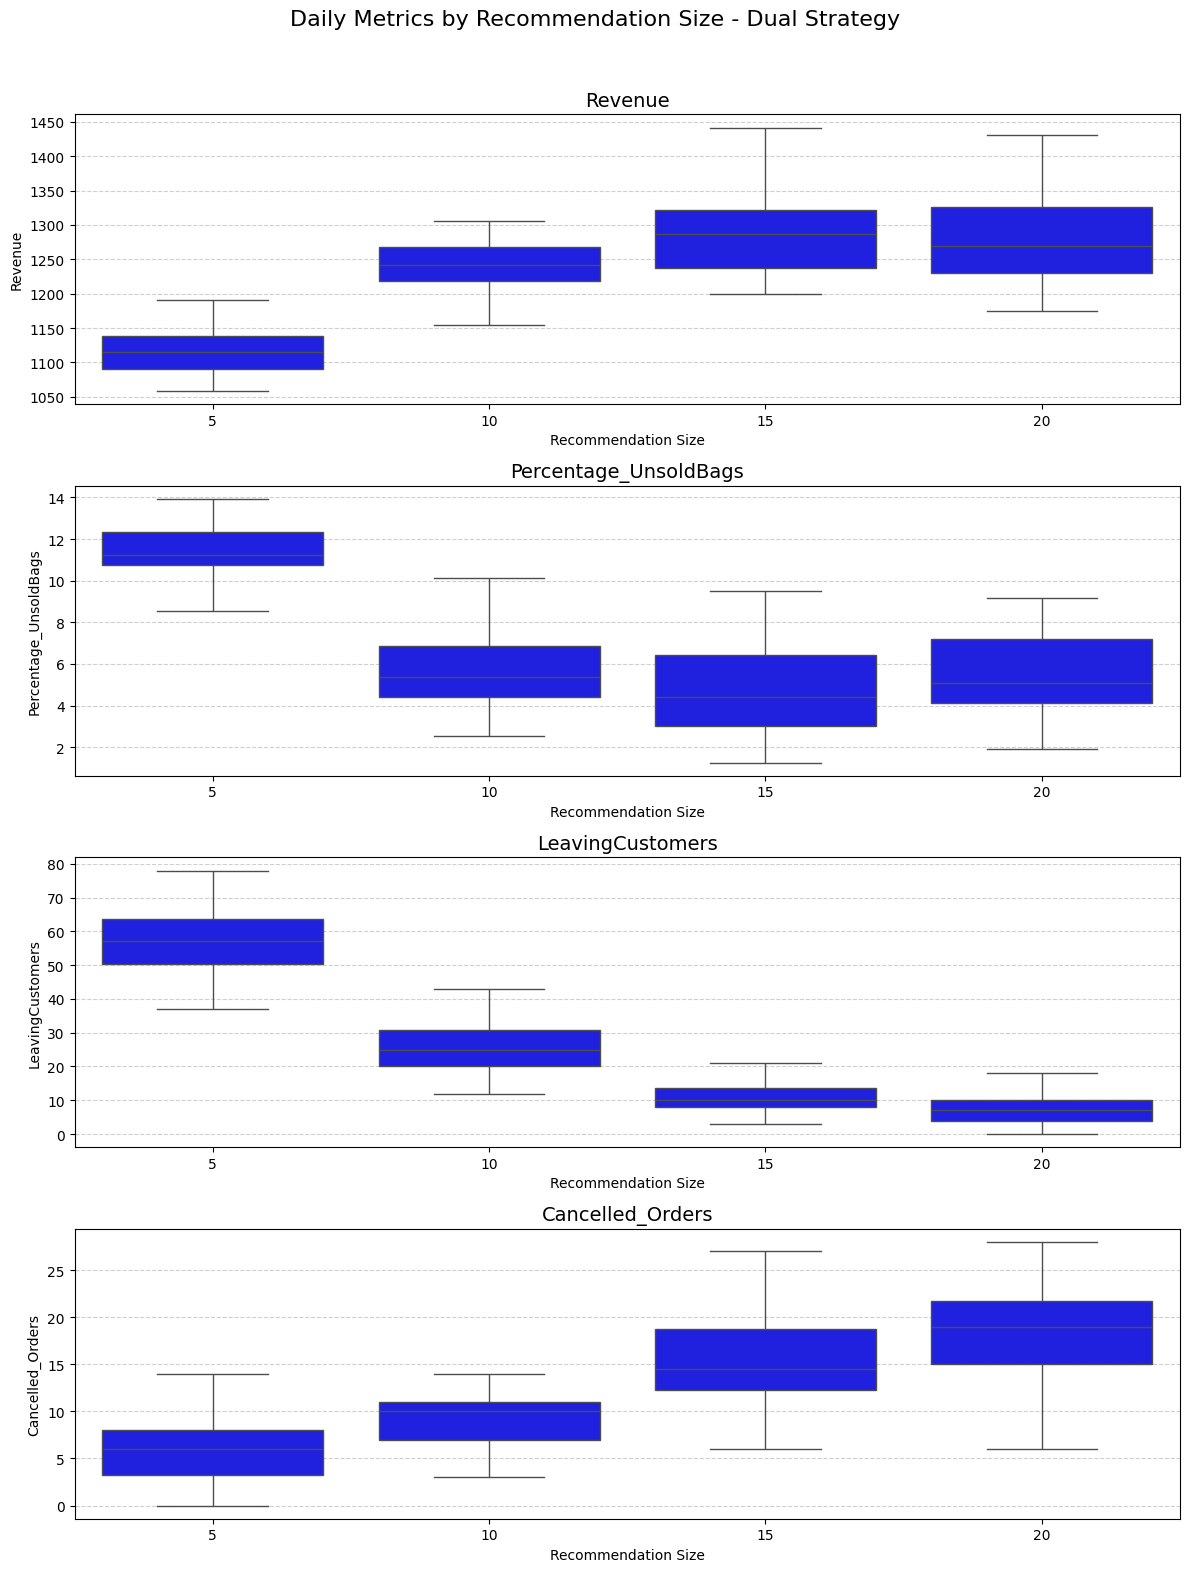

In [ ]:
metrics = ["Revenue", "Percentage_UnsoldBags", "LeavingCustomers", "Cancelled_Orders"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 16))
fig.suptitle("Daily Metrics by Recommendation Size - Dual Strategy", fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.boxplot(
        x="Recommendation Size",
        y=metric,
        data=runSumulationDual,
        ax=ax,
        color='blue',
        showfliers=False
    )

    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("Recommendation Size")
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## **DRAFT**

In [ ]:
def simulate_(days, size, scalePar, thetaPar, algorithmChoice):

    end_of_day_metrics = []

    for day in range(1, days + 1):

        end_of_day = {
              'Recommendation Size': size,
              'Revenue': 0,
              'SoldBags': 0,
              'UnSoldBags': 0,
              'LeavingCustomers': 0,
              'BagsAvailable': 0,
              'Percentage_UnsoldBags': 0,
              'Cancelled_Orders': 0,
              'ZeroDemand_Stores': 0,
              'Waste_to_Customer': []   # per customer bag size
          }

        # Initialize stores
        stores = storesSubset(scalePar, days)
        AVG_STORE_RATING = np.mean([store.storeRating for store in stores])

        for store in stores:
        # store.bagPrice = BagPrice_Temp
          multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scalePar))
          store.valuation = (store.bagPrice * multiplier)
          key = (store.storeID, day)
          if key in waste_dict:
              store.realizedWaste = waste_dict[key]

        daily_bags_available = sum(store.bagsAvailable for store in stores)

        # Generate customer arrivals for the day
        customersRange = 0.85*daily_bags_available                # 85% of bags
        # print(customersRange)

        daily_arrivals = generate_customer_arrivals(stores, customersRange, scalePar, thetaPar)

        customers = [
            Customer(
                customerID=arrival['Customer ID'],
                customerArrival=arrival['Arrival Time'],
                status=False
            )
            for arrival in daily_arrivals
        ]

        end_of_day['DailyBagsAvailable'] = daily_bags_available

        for customer in customers:
          recommendation_strategy = algorithmChoice(stores, size=size)
          purchase_made = process_customers(customer, recommendation_strategy, daily_arrivals)

          if purchase_made:
              for store in stores:
                  if customer.customerChoice == store.storeID:
                      end_of_day['Revenue'] += store.bagPrice
                      # print(f"revenue so far: {end_of_day['Revenue']}")
                      # mid_day['Revenue'] += store.bagPrice
                      end_of_day['SoldBags'] += 1
          if not purchase_made:
              end_of_day['LeavingCustomers'] += 1
              # mid_day['LeavingCustomers'] += 1

        # if random.random() < 0.3:
        #     snapshot(stores, customers)

        waste_to_customer = 0
        for store in stores:
            if store.demand >= store.realizedWaste:
                # print(f" Store {store.storeID} Store Demand is {store.demand} and realized waste is {store.realizedWaste}")
                store.CancelledOrders = (store.demand - store.realizedWaste)
                # print(f" Store {store.storeID} has {store.CancelledOrders} Cancelled Orders")
                end_of_day['Cancelled_Orders'] += (store.demand - store.realizedWaste)
                lost_revenue = store.CancelledOrders * store.bagPrice
                end_of_day['Revenue'] -= lost_revenue
                store.remainingBags = 0
                end_of_day['Waste_to_Customer'].append(1)

            if store.demand <= store.realizedWaste and store.demand != 0:
                waste_to_customer = store.realizedWaste / store.demand
                # print(f"{store.storeName} has realized waste {store.realizedWaste} and a demand of {store.demand}")
                # print(f"Resulting in a waste {waste_to_customer}, the store valuation is {store.valuation} \n")
                end_of_day['Waste_to_Customer'].append(waste_to_customer)
                store.remainingBags = 0

            if store.demand == 0:
                end_of_day['ZeroDemand_Stores'] += 1

        # for store in stores:
        #   print(store)
        # print(end_of_day['Waste_to_Customer'])


        # Calculate unsold bags
        end_of_day['UnSoldBags'] = sum(store.remainingBags for store in stores)
        daily_unsold_bags = end_of_day['UnSoldBags']
        end_of_day['Percentage_UnsoldBags'] = (daily_unsold_bags / daily_bags_available * 100) if daily_bags_available > 0 else 0

        # print(f"Day {day} - UnSoldBags: {daily_unsold_bags}, BagsAvailable: {daily_bags_available}, Percentage: {end_of_day['Percentage_UnsoldBags']}")

        # Save Midday Metrics
        # mid_day_metrics[size].append(mid_day)
        end_of_day_metrics.append(end_of_day)

    # midday_data = pd.concat([pd.DataFrame(mid_day_metrics[size]) for size in recommendation_sizes], ignore_index=True)
    # end_of_day_data = pd.concat([pd.DataFrame(end_of_day_metrics[size]) for size in recommendation_sizes], ignore_index=True)

    return pd.DataFrame(end_of_day_metrics)

In [ ]:
def simulateDiffSizes_(days, recommendation_sizes, scalePar, thetaPar, algorithmChoice):

    end_of_day_metrics = {size: [] for size in recommendation_sizes}

    for day in range(1, days + 1):
      for size in recommendation_sizes:

          end_of_day = {
                'Recommendation Size': size,
                'Revenue': 0,
                'SoldBags': 0,
                'UnSoldBags': 0,
                'LeavingCustomers': 0,
                'BagsAvailable': 0,
                'Percentage_UnsoldBags': 0,
                'Cancelled_Orders': 0,
                'ZeroDemand_Stores': 0,
                'Waste_to_Customer': []   # per customer bag size
            }

          stores = storesSubset(scalePar, days)
          for store in stores:
            multiplier = 2 / (1 + np.exp((Config.AVG_STORE_RATING - store.storeRating) / scalePar))
            store.valuation = (store.bagPrice * multiplier)
            key = (store.storeID, day)
            if key in waste_dict:
                store.realizedWaste = waste_dict[key]


          daily_bags_available = sum(store.bagsAvailable for store in stores)

          customersRange = 0.85*daily_bags_available    # 85% of bags
          # print(customersRange)

          daily_arrivals = generate_customer_arrivals(stores, customersRange, scalePar, thetaPar)


          customers = [
              Customer(
                  customerID=arrival['Customer ID'],
                  customerArrival=arrival['Arrival Time'],
                  status=False
              )
              for arrival in daily_arrivals
          ]

          end_of_day['DailyBagsAvailable'] = daily_bags_available


          for customer in customers:
            recommendation_strategy = algorithmChoice(stores, size=size)
            # for s in recommendation_strategy:
            #   print(s)
            purchase_made = process_customers(customer, recommendation_strategy, daily_arrivals)

            if purchase_made:
                for store in stores:
                    if customer.customerChoice == store.storeID:
                        end_of_day['Revenue'] += store.bagPrice
                        # print(f"revenue so far: {end_of_day['Revenue']}")
                        # mid_day['Revenue'] += store.bagPrice
                        end_of_day['SoldBags'] += 1
            if not purchase_made:
                end_of_day['LeavingCustomers'] += 1
                # mid_day['LeavingCustomers'] += 1

          waste_to_customer = 0
          for store in stores:
              if store.demand >= store.realizedWaste:
                  # print(f" Store {store.storeID} Store Demand is {store.demand} and realized waste is {store.realizedWaste}")
                  store.CancelledOrders = (store.demand - store.realizedWaste)
                  # print(f" Store {store.storeID} has {store.CancelledOrders} Cancelled Orders")
                  end_of_day['Cancelled_Orders'] += (store.demand - store.realizedWaste)
                  lost_revenue = store.CancelledOrders * store.bagPrice
                  # end_of_day['Revenue'] -= lost_revenue
                  store.remainingBags = 0
                  end_of_day['Waste_to_Customer'].append(1)

              if store.demand <= store.realizedWaste and store.demand != 0:
                  waste_to_customer = store.realizedWaste / store.demand
                  end_of_day['Waste_to_Customer'].append(waste_to_customer)
                  store.remainingBags = 0

              if store.demand == 0:
                  end_of_day['ZeroDemand_Stores'] += 1

          # for store in stores:
          #   print(store)
          # print(end_of_day['Waste_to_Customer'])


          # Calculate unsold bags
          end_of_day['UnSoldBags'] = sum(store.remainingBags for store in stores)
          daily_unsold_bags = end_of_day['UnSoldBags']
          end_of_day['Percentage_UnsoldBags'] = (daily_unsold_bags / daily_bags_available * 100) if daily_bags_available > 0 else 0

          # print(f"Day {day} - UnSoldBags: {daily_unsold_bags}, BagsAvailable: {daily_bags_available}, Percentage: {end_of_day['Percentage_UnsoldBags']}")

          # Save Midday Metrics
          # mid_day_metrics[size].append(mid_day)
          end_of_day_metrics[size].append(end_of_day)

    # midday_data = pd.concat([pd.DataFrame(mid_day_metrics[size]) for size in recommendation_sizes], ignore_index=True)
    end_of_day_data = pd.concat([pd.DataFrame(end_of_day_metrics[size]) for size in recommendation_sizes], ignore_index=True)

    return end_of_day_data

In [ ]:
Config.THETA = 0.5
Config.SCALE = 1
Recom_sizes = [5,10,15,20]
Config.DAYS = 30

BenchmarkSizes = simulateDiffSizes_(days=Config.DAYS,
                      recommendation_sizes=Recom_sizes,
                      scalePar = Config.SCALE,
                      thetaPar=Config.THETA,
                      algorithmChoice=penaltyBenchmark_)

LinearSizes_ = simulateDiffSizes_(days=Config.DAYS,
                      recommendation_sizes=Recom_sizes,
                      scalePar = Config.SCALE,
                      thetaPar=Config.THETA,
                      algorithmChoice=penaltyLinear_
)

ExpSizes_ = simulateDiffSizes_(days=Config.DAYS,
                      recommendation_sizes=Recom_sizes,
                      scalePar = Config.SCALE,
                      thetaPar=Config.THETA,
                      algorithmChoice=penaltyExp_
)

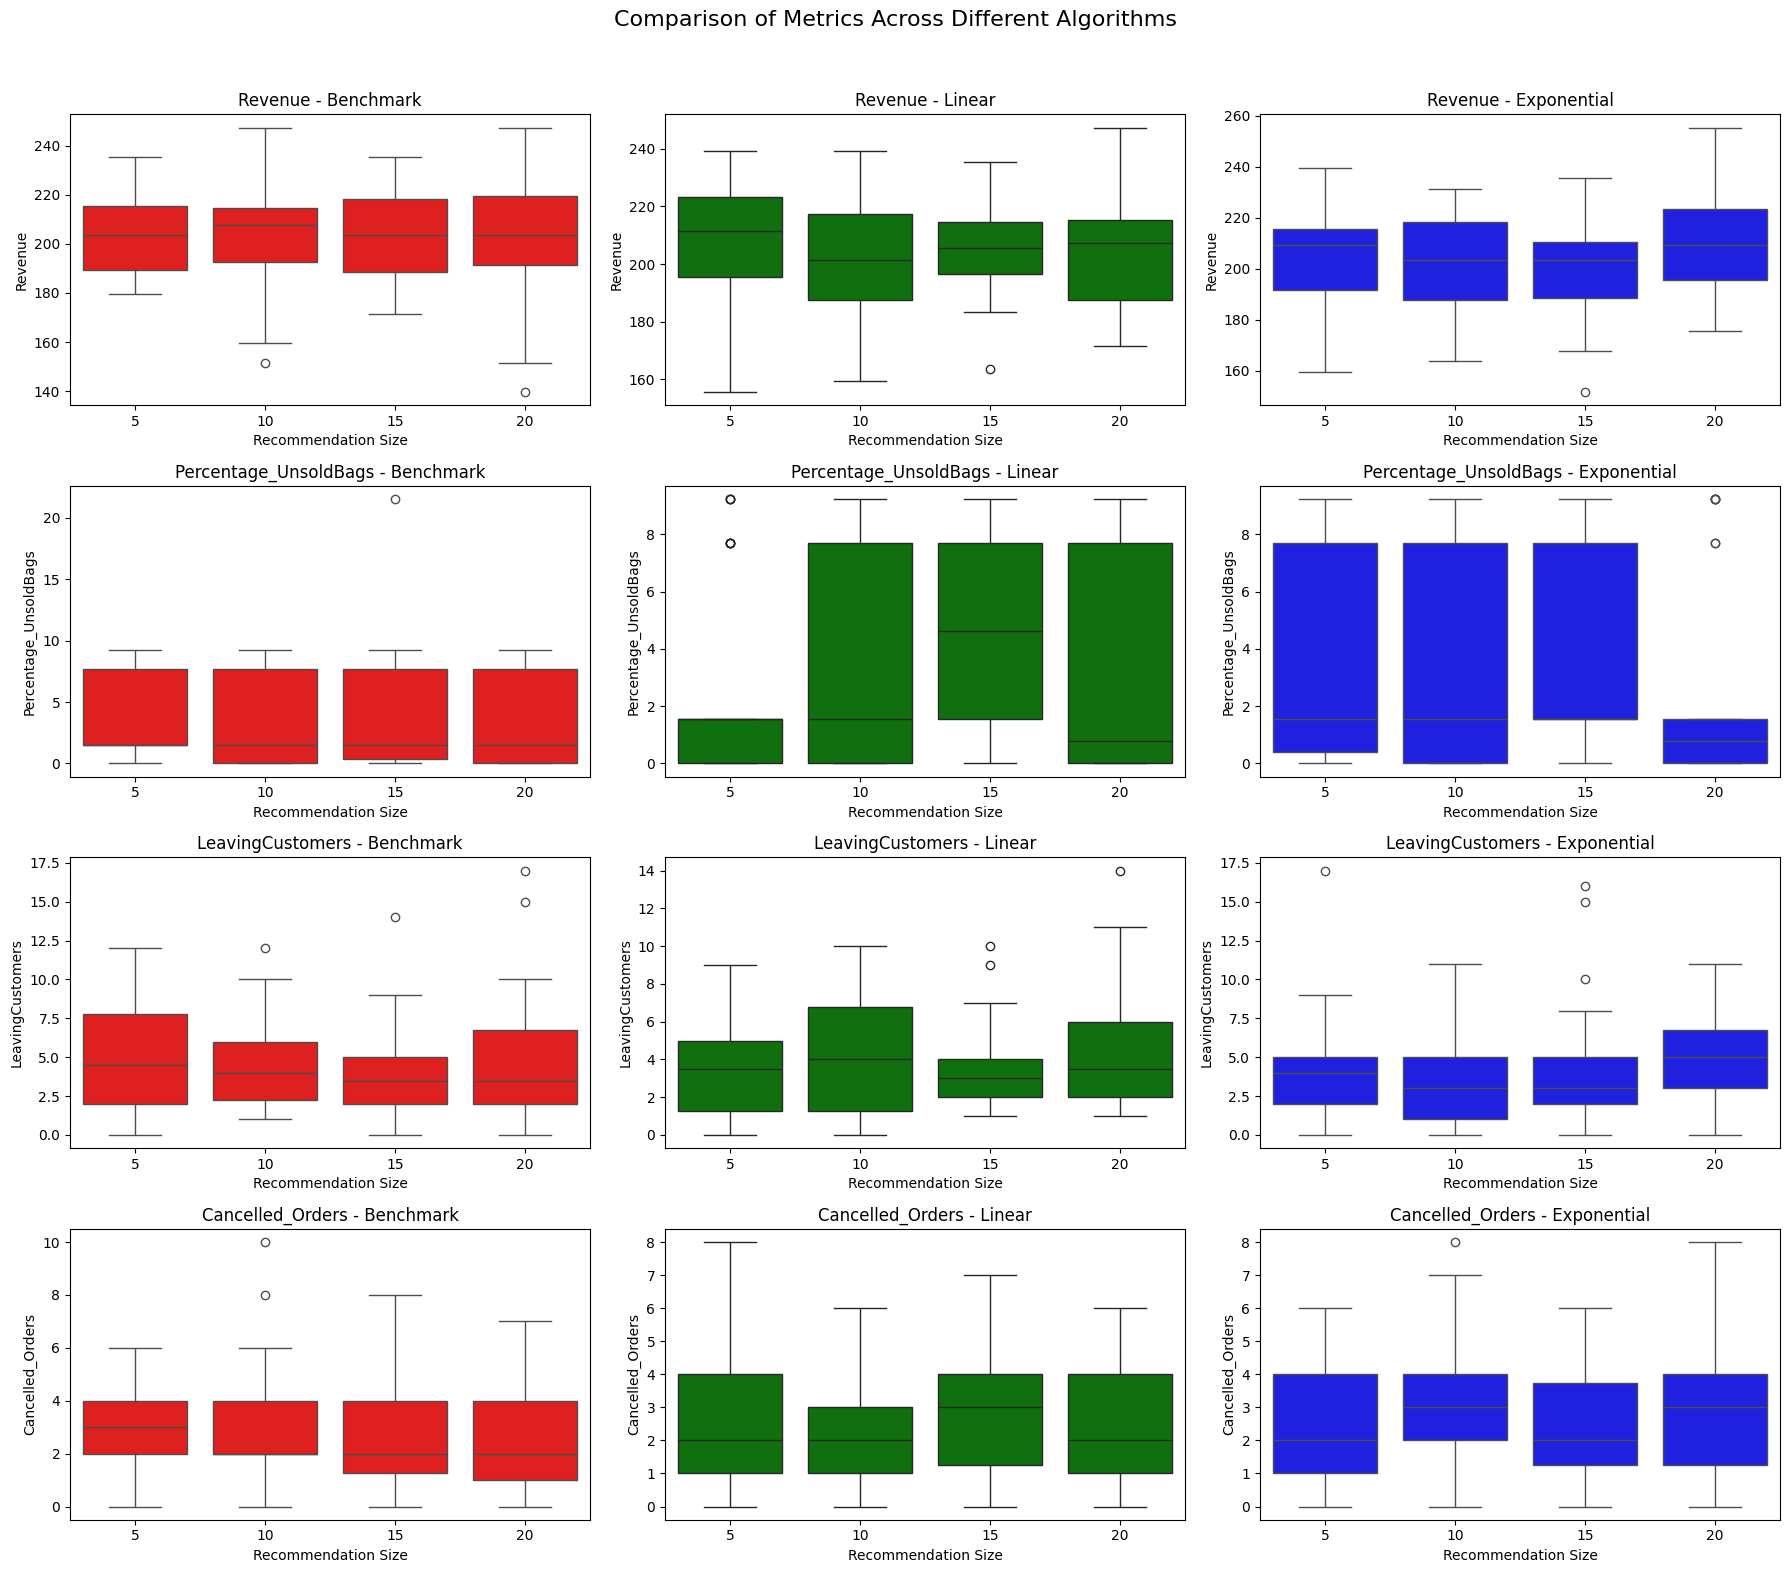

In [ ]:
metrics = ["Revenue", "Percentage_UnsoldBags", "LeavingCustomers", "Cancelled_Orders"]

colors = {
    "Benchmark": ("red", BenchmarkSizes),
    "Linear": ("green", LinearSizes_),
    "Exponential": ("blue", ExpSizes_),
}

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
fig.suptitle("Comparison of Metrics Across Different Algorithms", fontsize=16)

for row_idx, metric in enumerate(metrics):
    for col_idx, (algorithm, (color, dataset)) in enumerate(colors.items()):
        ax = axes[row_idx, col_idx]
        sns.boxplot(x="Recommendation Size", y=metric, data=dataset, color=color, ax=ax)
        ax.set_title(f"{metric} - {algorithm}", fontsize=12)
        ax.set_xlabel("Recommendation Size")
        ax.set_ylabel(metric)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# def simulateDiffSizes_(days, recommendation_sizes, attractiveness_array, scalePar, thetaPar, algorithmChoice):
#     all_results = []
#     all_customer_vals = []

#     for attractiveness in attractiveness_array:
#         print(f"Running simulation with attractiveness = {attractiveness}")

#         results = {alg_name: {size: [] for size in recommendation_sizes} for alg_name in algorithms}

#         for day in range(1, days + 1):
#             stores = stores_initialization()
#             AVG_STORE_RATING = np.mean([store.storeRating for store in stores])

#             for store in stores:
#                 multiplier = 2 / (1 + np.exp((AVG_STORE_RATING - store.storeRating) / scalePar))
#                 store.valuation = multiplier * store.bagPrice
#                 key = (store.storeID, day)
#                 if key in waste_dict:
#                     store.realizedWaste = waste_dict[key]

#             daily_bags_available = sum(store.bagsAvailable for store in stores)
#             customersRange = 0.85 * daily_bags_available
#             daily_arrivals, storesValuations = generate_customer_arrivals(
#                 stores, AVG_STORE_RATING, customersRange, scalePar, thetaPar, attractiveness
#             )

#             customers = [
#                 Customer(
#                     customerID=arrival['Customer ID'],
#                     customerArrival=arrival['Arrival Time'],
#                     status=False
#                 )
#                 for arrival in daily_arrivals
#             ]

#             TotalCustomerValuations = pd.DataFrame(storesValuations)

#             for alg_name, algorithmChoice in algorithms.items():
#                 for size in recommendation_sizes:
#                     copyCustomers = copy.deepcopy(customers)
#                     copyStores = copy.deepcopy(stores)

#                     end_of_day = {
#                         'Algorithm': alg_name,
#                         'Day': day,
#                         'Recommendation Size': size,
#                         'Revenue': 0,
#                         'SoldBags': 0,
#                         'UnSoldBags': 0,
#                         'LeavingCustomers': 0,
#                         'BagsAvailable': daily_bags_available,
#                         'Waste_Percentage': 0,
#                         'Cancelled_Orders': 0,
#                         'ZeroDemand_Stores': 0,
#                         'Waste_to_Customer': [],
#                         'Attractiveness': attractiveness
#                     }

#                     for customer in copyCustomers:
#                         recommendation_strategy = algorithmChoice(copyStores, size=size)
#                         purchase_made = process_customers(customer, recommendation_strategy, daily_arrivals)

#                         if purchase_made:
#                             for store in copyStores:
#                                 if customer.customerChoice == store.storeID:
#                                     end_of_day['Revenue'] += store.bagPrice
#                                     end_of_day['SoldBags'] += 1
#                         else:
#                             end_of_day['LeavingCustomers'] += 1

#                     for store in copyStores:
#                         if store.demand >= store.realizedWaste:
#                             store.CancelledOrders = store.demand - store.realizedWaste
#                             end_of_day['Cancelled_Orders'] += store.CancelledOrders
#                             end_of_day['Revenue'] -= store.CancelledOrders * store.bagPrice
#                             store.remainingBags = 0
#                             end_of_day['Waste_to_Customer'].append(1)

#                         elif store.demand < store.realizedWaste and store.demand != 0:
#                             waste_to_customer = store.realizedWaste / store.demand
#                             end_of_day['Waste_to_Customer'].append(waste_to_customer)
#                             store.remainingBags = 0

#                         if store.demand == 0:
#                             end_of_day['ZeroDemand_Stores'] += 1

#                     end_of_day['UnSoldBags'] = sum(store.remainingBags for store in copyStores)
#                     if daily_bags_available > 0:
#                         end_of_day['Waste_Percentage'] = (end_of_day['UnSoldBags'] / daily_bags_available) * 100

#                     results[alg_name][size].append(end_of_day)

#         # Collect results for this attractiveness level
#         for alg_name, size_data in results.items():
#             for size, metrics in size_data.items():
#                 df = pd.DataFrame(metrics)
#                 df['Algorithm'] = alg_name
#                 df['Recommendation Size'] = size
#                 df['Attractiveness'] = attractiveness
#                 all_results.append(df)

#         TotalCustomerValuations['Attractiveness'] = attractiveness
#         all_customer_vals.append(TotalCustomerValuations)

#     return pd.concat(all_results, ignore_index=True), pd.concat(all_customer_vals, ignore_index=True)